In [1]:
import openfl.native as fx
from openfl.federated import FederatedModel, FederatedDataSet

In [2]:
from importlib import reload
import sys

%load_ext autoreload
%autoreload 2

In [3]:
import DataSplitterMethods
data_splitter = DataSplitterMethods.SplitFunctionGenerator("Equal-Equal-Split")

## Load Dataset and Transfer 
### Define Torch Dataloader

In [4]:
import torch
import torchvision
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

## Replace here with path of your folder. 
dataset = torchvision.datasets.ImageFolder(root='/home/shivam/Documents/Gatech_Coursework/Semester 2/AIC/Final Project/content/gaussian_filtered_images/gaussian_filtered_images', transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

### Display data into train and valid sets

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

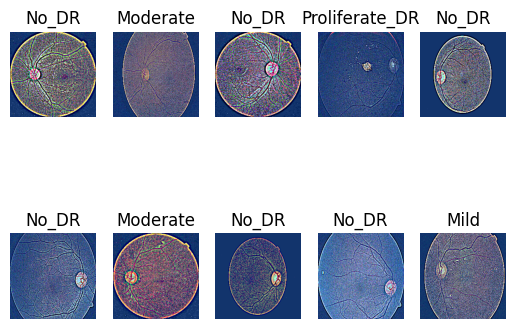

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def index_to_class_name(index, dataset):
    return dataset.classes[index]

len_images = 10
images, labels = next(iter(dataloader))
sample_indices = np.random.choice(len(images), len_images, replace=False)
sample_images = images[sample_indices]
sample_labels = labels[sample_indices]

for i, image in enumerate(sample_images):
    class_name = index_to_class_name(sample_labels[i], dataset)
    plt.subplot(2, 5, i+1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title(class_name)
    plt.axis('off')

plt.show() 

In [6]:
import matplotlib.pyplot as plt
import numpy as np

### Distribute data into train and valid data sets


In [7]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=False)
data, labels = next(iter(data_loader))
print("The data shape is {}".format(data.shape))

The data shape is torch.Size([3662, 3, 224, 224])


In [8]:
import torch.nn.functional as F
def split_and_return_train_valid(data, labels, split = 0.2):
  test_indices = np.random.rand(data.shape[0]) < split
  train_indices = ~test_indices
  train_data, test_data = data[train_indices], data[test_indices]
  train_labels, test_labels = labels[train_indices], labels[test_indices]
  train_labels, test_labels = F.one_hot(train_labels), F.one_hot(test_labels)
  return train_data, train_labels, test_data, test_labels

train_data, train_labels, test_data, test_labels = split_and_return_train_valid(data, labels) 
print("Train Data Length is {}".format(len(train_data)))
print("Test Data Length is {}".format(len(test_data)))

Train Data Length is 2935
Test Data Length is 727


In [1]:
from openfl.federated import FederatedModel,FederatedDataSet

from openfl.utilities.data_splitters import DirichletNumPyDataSplitter
from openfl.utilities.data_splitters import EqualNumPyDataSplitter
from openfl.utilities.data_splitters import LogNormalNumPyDataSplitter
from openfl.utilities.data_splitters import RandomNumPyDataSplitter

batch_size = 16
num_classes = 5
fl_data = FederatedDataSet(train_data, train_labels, test_data, test_labels, 
                           batch_size = batch_size , num_classes = num_classes, 
                           train_splitter=data_splitter)

NameError: name 'train_data' is not defined

###  Define Model - Pretrained Model
We can use a pretrained model like Inception or VGG Net to perform classification. These have already been pretrained on large-scale image data and we need to train only some final linear layers.

In [10]:

import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

class InceptionV1(nn.Module):
    def __init__(self, num_classes=5):
        super(InceptionV1, self).__init__()
        self.num_classes = num_classes
        self.inception = models.googlenet(pretrained=True)
        
        for param in self.inception.parameters():
            param.requires_grad = False
            
        self.inception.fc = nn.Linear(self.inception.fc.in_features, num_classes)

    def forward(self, x):
        x = self.inception(x)
        return F.log_softmax(x, dim=1)
    
optimizer = lambda x: optim.Adam(x, lr=1e-4)

def cross_entropy(output, target):
    """Binary cross-entropy metric
    """
    return F.binary_cross_entropy_with_logits(input=output,target=target.float())


In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(InceptionV1())

## Earlier Parameters: 51386181

/home/shivam/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/shivam/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


5125

In [12]:
net = InceptionV1()
net(data[3:8]).shape

torch.Size([5, 5])

In [13]:
fl_model = FederatedModel(build_model=InceptionV1, optimizer=optimizer, loss_fn=cross_entropy, data_loader=fl_data)

tried to remove tensor: __opt_state_needed not present in the tensor dict


### Define OpenFlow Plan

In [14]:
NUM_COLLABORATORS = 5
collaborator_list = [str(i) for i in range(NUM_COLLABORATORS)]
experiment_collaborators = {col_name:col_model for col_name, col_model \
                                 in zip(collaborator_list, fl_model.setup(len(collaborator_list)))}

584
584
584
584
584


tried to remove tensor: __opt_state_needed not present in the tensor dict
tried to remove tensor: __opt_state_needed not present in the tensor dict
tried to remove tensor: __opt_state_needed not present in the tensor dict
tried to remove tensor: __opt_state_needed not present in the tensor dict
tried to remove tensor: __opt_state_needed not present in the tensor dict


In [15]:
fx.init('torch_cnn_mnist', col_names=collaborator_list)

Creating Workspace Directories
Creating Workspace Templates
Defaulting to user installation because normal site-packages is not writeable

New workspace directory structure:
workspace
├── envoy_config.yaml
├── cert
├── agg_to_col_3_signed_cert.zip
├── spam_metric.log
├── agg_to_col_1_signed_cert.zip
├── agg_to_col_4_signed_cert.zip
├── shard_descriptor.py
├── save
│   ├── torch_cnn_mnist_init.pbuf
│   ├── keras_cnn_mnist_init.pbuf
│   ├── torch_cnn_mnist_last.pbuf
│   └── torch_cnn_mnist_best.pbuf
├── logs
│   └── cnn_mnist
│       ├── events.out.tfevents.1681269401.Roger.8557.0
│       ├── events.out.tfevents.1681269659.Roger.9184.0
│       ├── events.out.tfevents.1680565291.Roger.63976.0
│       ├── events.out.tfevents.1681270134.Roger.10870.0
│       ├── events.out.tfevents.1681267520.Roger.21655.0
│       ├── events.out.tfevents.1680564705.Roger.56398.2
│       ├── events.out.tfevents.1680564647.Roger.56398.1
│       ├── events.out.tfevents.1681266567.Roger.17464.0
│       └── even

│   ├── pt_cnn.py
│   ├── tfmnist_inmemory.py
│   ├── mnist_utils.py
│   ├── keras_cnn.py
│   ├── __init__.py
│   ├── ptmnist_inmemory.py
│   └── __pycache__
│       ├── __init__.cpython-38.pyc
│       └── mnist_utils.cpython-38.pyc
├── agg_to_col_0_signed_cert.zip
├── agg_to_col_2_signed_cert.zip
├── .workspace
├── requirements.txt
├── data
├── plan
│   ├── defaults
│   ├── data.yaml
│   ├── plan.yaml
│   └── cols.yaml
└── agg_to_col_two_signed_cert.zip

8 directories, 38 files
Setting Up Certificate Authority...

1.  Create Root CA
1.1 Create Directories
1.2 Create Database
1.3 Create CA Request and Certificate
2.  Create Signing Certificate
2.1 Create Directories
2.2 Create Database
2.3 Create Signing Certificate CSR
2.4 Sign Signing Certificate CSR
3   Create Certificate Chain

Done.
Creating AGGREGATOR certificate key pair with following settings: CN=roger, SAN=DNS:roger
  Writing AGGREGATOR certificate key pair to: /home/shivam/Documents/Gatech_Coursework/Semester 2/AIC/Final Pro

In [17]:
final_fl_model = fx.run_experiment(experiment_collaborators, override_config={"aggregator.settings.rounds_to_train": 20})

[23:43:28] INFO     Updating aggregator.settings.rounds_to_train to 20...                                                                          ]8;id=114820;file:///usr/local/lib/python3.8/dist-packages/openfl/native/native.py\native.py]8;;\:]8;id=487146;file:///usr/local/lib/python3.8/dist-packages/openfl/native/native.py#102\102]8;;\

           INFO     FL-Plan hash is 164df001446fef577a3b2260bf97e83d497b8dbb4f803517902d39a10a643455d3c3e3e1532b03055d7385aed6ebf7ba                 ]8;id=290130;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=174055;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/plan/plan.py#235\235]8;;\

           INFO     Building 🡆 Object NoCompressionPipeline from openfl.pipelines Module.                                                            ]8;id=409451;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=389733;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/plan/plan.py#171\171]8;;\

           INFO     Creating Initial Weights File    🠆 save/torch_cnn_mnist_init.pbuf                                                              ]8;id=313361;file:///usr/local/lib/python3.8/dist-packages/openfl/native/native.py\native.py]8;;\:]8;id=133159;file:///usr/local/lib/python3.8/dist-packages/openfl/native/native.py#277\277]8;;\

           INFO     Starting Experiment...                                                                                                         ]8;id=761180;file:///usr/local/lib/python3.8/dist-packages/openfl/native/native.py\native.py]8;;\:]8;id=440112;file:///usr/local/lib/python3.8/dist-packages/openfl/native/native.py#281\281]8;;\

           INFO     Building 🡆 Object RandomGroupedAssigner from openfl.component Module.                                                            ]8;id=755994;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=643063;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/plan/plan.py#171\171]8;;\

           INFO     Building 🡆 Object CutoffTimeBasedStragglerHandling from openfl.component.straggler_handling_functions Module.                    ]8;id=549940;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=696806;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/plan/plan.py#171\171]8;;\

           INFO     Importing 🡆 Object write_metric from src.mnist_utils Module.                                                                     ]8;id=345586;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=583116;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/plan/plan.py#199\199]8;;\

           INFO     Building 🡆 Object Aggregator from openfl.component Module.                                                                       ]8;id=513285;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=408603;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/plan/plan.py#171\171]8;;\

           INFO     Using custom log metric: <function write_metric at 0x7fee1b875670>                                                          ]8;id=620486;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=860676;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#97\97]8;;\

           INFO     Building 🡆 Object Collaborator from openfl.component Module.                                                                     ]8;id=180739;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=367268;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/plan/plan.py#171\171]8;;\

           INFO     Building 🡆 Object Collaborator from openfl.component Module.                                                                     ]8;id=663659;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=10276;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/plan/plan.py#171\171]8;;\

           INFO     Building 🡆 Object Collaborator from openfl.component Module.                                                                     ]8;id=907053;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=492;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/plan/plan.py#171\171]8;;\

           INFO     Building 🡆 Object Collaborator from openfl.component Module.                                                                     ]8;id=129690;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=345407;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/plan/plan.py#171\171]8;;\

           INFO     Building 🡆 Object Collaborator from openfl.component Module.                                                                     ]8;id=783040;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=89504;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/plan/plan.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=492619;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=540638;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 0 for round 0                                                                                ]8;id=372845;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=468737;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=502676;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=617595;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:43:29] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=145245;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=233438;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 0, collaborator 0 is sending metric for task aggregated_model_validation: acc     0.123288                         ]8;id=442579;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=921318;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for aggregated_model_validation, round 0                                            ]8;id=884238;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=510345;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 0, collaborator validate_agg aggregated_model_validation result acc:      0.123288                                   ]8;id=785334;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=271908;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=987228;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=802044;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 0 round                                                                                                      ]8;id=643279;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=106317;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:43:30] METRIC   Round 0, collaborator 0 is sending metric for task train: cross_entropy 0.158065                                         ]8;id=860009;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=34890;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for train, round 0                                                                  ]8;id=813299;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=563456;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 0, collaborator metric train result cross_entropy:        0.158065                                                   ]8;id=204771;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=824545;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:43:31] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=554304;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=156007;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 0, collaborator 0 is sending metric for task locally_tuned_model_validation: acc  0.123288                         ]8;id=543137;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=8777;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for locally_tuned_model_validation, round 0                                         ]8;id=157520;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=824892;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 0, collaborator validate_local locally_tuned_model_validation result acc: 0.123288                                   ]8;id=259131;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=916385;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 0 for round 0...                                                                                  ]8;id=787090;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=405600;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=79021;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=254713;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 1 for round 0                                                                                ]8;id=922484;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=559470;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=925839;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=124314;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=72537;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=856092;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:43:32] METRIC   Round 0, collaborator 1 is sending metric for task aggregated_model_validation: acc     0.089041                         ]8;id=742004;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=975546;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for aggregated_model_validation, round 0                                            ]8;id=765460;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=514909;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 0, collaborator validate_agg aggregated_model_validation result acc:      0.089041                                   ]8;id=438343;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=195193;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=557568;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=554180;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 0 round                                                                                                      ]8;id=509454;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=260404;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:43:33] METRIC   Round 0, collaborator 1 is sending metric for task train: cross_entropy 0.280926                                         ]8;id=92963;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=245569;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for train, round 0                                                                  ]8;id=232764;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=971638;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 0, collaborator metric train result cross_entropy:        0.280926                                                   ]8;id=7488;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=958396;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=666579;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=15388;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 0, collaborator 1 is sending metric for task locally_tuned_model_validation: acc  0.089041                         ]8;id=506973;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=186339;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for locally_tuned_model_validation, round 0                                         ]8;id=269681;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=555090;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 0, collaborator validate_local locally_tuned_model_validation result acc: 0.089041                                   ]8;id=250537;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=544318;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 1 for round 0...                                                                                  ]8;id=351203;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=819039;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=428536;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=975137;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 2 for round 0                                                                                ]8;id=470138;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=125324;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=785962;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=83605;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:43:34] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=644714;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=962579;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 0, collaborator 2 is sending metric for task aggregated_model_validation: acc     0.110345                         ]8;id=184226;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=499528;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for aggregated_model_validation, round 0                                            ]8;id=333191;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=738230;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 0, collaborator validate_agg aggregated_model_validation result acc:      0.110345                                   ]8;id=393248;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=58218;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=257302;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=570872;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 0 round                                                                                                      ]8;id=361957;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=291476;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:43:35] METRIC   Round 0, collaborator 2 is sending metric for task train: cross_entropy 0.369250                                         ]8;id=384156;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=827558;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for train, round 0                                                                  ]8;id=865955;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=874507;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 0, collaborator metric train result cross_entropy:        0.369250                                                   ]8;id=235834;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=73638;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=745857;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=33359;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:43:36] METRIC   Round 0, collaborator 2 is sending metric for task locally_tuned_model_validation: acc  0.131034                         ]8;id=389310;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=691284;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for locally_tuned_model_validation, round 0                                         ]8;id=67647;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=21219;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 0, collaborator validate_local locally_tuned_model_validation result acc: 0.131034                                   ]8;id=868984;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=99169;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 2 for round 0...                                                                                  ]8;id=518509;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=650862;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=448393;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=484990;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 3 for round 0                                                                                ]8;id=411307;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=576497;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=699530;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=668456;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=92883;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=512997;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:43:37] METRIC   Round 0, collaborator 3 is sending metric for task aggregated_model_validation: acc     0.096552                         ]8;id=285218;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=588645;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for aggregated_model_validation, round 0                                            ]8;id=58791;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=831911;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 0, collaborator validate_agg aggregated_model_validation result acc:      0.096552                                   ]8;id=94393;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=683738;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=737157;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=18527;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 0 round                                                                                                      ]8;id=457721;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=253121;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:43:38] METRIC   Round 0, collaborator 3 is sending metric for task train: cross_entropy 0.210800                                         ]8;id=776634;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=185803;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for train, round 0                                                                  ]8;id=64034;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=511644;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 0, collaborator metric train result cross_entropy:        0.210800                                                   ]8;id=258961;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=941017;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=832170;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=589773;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 0, collaborator 3 is sending metric for task locally_tuned_model_validation: acc  0.096552                         ]8;id=270461;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=137369;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for locally_tuned_model_validation, round 0                                         ]8;id=485448;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=209765;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 0, collaborator validate_local locally_tuned_model_validation result acc: 0.096552                                   ]8;id=94016;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=242265;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 3 for round 0...                                                                                  ]8;id=358348;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=109092;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=981857;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=236766;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 4 for round 0                                                                                ]8;id=52977;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=878109;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=970209;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=107694;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:43:39] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=796362;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=102946;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 0, collaborator 4 is sending metric for task aggregated_model_validation: acc     0.110345                         ]8;id=179918;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=425131;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for aggregated_model_validation, round 0                                            ]8;id=416264;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=843891;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 0, collaborator validate_agg aggregated_model_validation result acc:      0.110345                                   ]8;id=395799;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=172356;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=776065;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=936449;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 0 round                                                                                                      ]8;id=572677;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=995461;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:43:40] METRIC   Round 0, collaborator 4 is sending metric for task train: cross_entropy 0.199151                                         ]8;id=172717;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=335095;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for train, round 0                                                                  ]8;id=169809;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=412369;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 0, collaborator metric train result cross_entropy:        0.199151                                                   ]8;id=55763;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=588890;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=708313;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=319447;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:43:41] METRIC   Round 0, collaborator 4 is sending metric for task locally_tuned_model_validation: acc  0.110345                         ]8;id=161768;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=358773;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for locally_tuned_model_validation, round 0                                         ]8;id=572870;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=986961;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 0, collaborator validate_local locally_tuned_model_validation result acc: 0.110345                                   ]8;id=818189;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=230042;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           METRIC   Round 0, aggregator: aggregated_model_validation <openfl.interface.aggregation_functions.weighted_average.WeightedAverage  ]8;id=987258;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=642434;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    object at 0x7fee3d6f11f0> acc:        0.105915                                                                                              

           METRIC   Round 0: saved the best model with score 0.105915                                                                          ]8;id=283066;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=407490;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#858\858]8;;\

           METRIC   Round 0, aggregator: locally_tuned_model_validation                                                                        ]8;id=715344;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=383534;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    <openfl.interface.aggregation_functions.weighted_average.WeightedAverage object at 0x7fee3d6f11f0> acc:     0.110041                        

           METRIC   Round 0, aggregator: train <openfl.interface.aggregation_functions.weighted_average.WeightedAverage object at              ]8;id=707083;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=619476;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    0x7fee3d6f11f0> cross_entropy:    0.243639                                                                                                  

[23:43:44] INFO     Saving round 1 model...                                                                                                    ]8;id=335906;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=453365;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#894\894]8;;\

           INFO     Starting round 1...                                                                                                        ]8;id=232280;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=463825;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#901\901]8;;\

           INFO     All tasks completed on 4 for round 0...                                                                                  ]8;id=931259;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=260120;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=744886;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=103450;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 0 for round 1                                                                                ]8;id=208783;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=626110;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=197215;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=407302;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:43:45] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=276920;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=493589;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 1, collaborator 0 is sending metric for task aggregated_model_validation: acc     0.123288                         ]8;id=216617;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=522577;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for aggregated_model_validation, round 1                                            ]8;id=464695;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=7882;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 1, collaborator validate_agg aggregated_model_validation result acc:      0.123288                                   ]8;id=524370;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=889728;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=887993;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=819365;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 1 round                                                                                                      ]8;id=667431;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=18636;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:43:46] METRIC   Round 1, collaborator 0 is sending metric for task train: cross_entropy 0.156743                                         ]8;id=121115;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=12559;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for train, round 1                                                                  ]8;id=437059;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=662014;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 1, collaborator metric train result cross_entropy:        0.156743                                                   ]8;id=384738;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=327360;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:43:47] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=849317;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=889322;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 1, collaborator 0 is sending metric for task locally_tuned_model_validation: acc  0.123288                         ]8;id=419203;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=1350;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for locally_tuned_model_validation, round 1                                         ]8;id=823380;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=300640;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 1, collaborator validate_local locally_tuned_model_validation result acc: 0.123288                                   ]8;id=398291;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=939079;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 0 for round 1...                                                                                  ]8;id=640067;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=317423;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=376882;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=907967;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 1 for round 1                                                                                ]8;id=470387;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=974425;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=859888;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=327232;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:43:48] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=55413;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=899999;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 1, collaborator 1 is sending metric for task aggregated_model_validation: acc     0.089041                         ]8;id=741887;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=756470;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for aggregated_model_validation, round 1                                            ]8;id=90225;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=857807;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 1, collaborator validate_agg aggregated_model_validation result acc:      0.089041                                   ]8;id=596733;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=639256;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=999926;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=398894;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 1 round                                                                                                      ]8;id=367512;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=516014;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:43:49] METRIC   Round 1, collaborator 1 is sending metric for task train: cross_entropy 0.271903                                         ]8;id=465531;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=823129;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for train, round 1                                                                  ]8;id=575707;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=428516;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 1, collaborator metric train result cross_entropy:        0.271903                                                   ]8;id=923813;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=830324;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=15686;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=134315;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:43:50] METRIC   Round 1, collaborator 1 is sending metric for task locally_tuned_model_validation: acc  0.089041                         ]8;id=732941;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=571737;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for locally_tuned_model_validation, round 1                                         ]8;id=3728;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=714320;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 1, collaborator validate_local locally_tuned_model_validation result acc: 0.089041                                   ]8;id=683839;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=253928;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 1 for round 1...                                                                                  ]8;id=223377;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=29392;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=965565;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=618914;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 2 for round 1                                                                                ]8;id=411352;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=798966;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=905339;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=593314;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:43:51] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=365567;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=488728;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 1, collaborator 2 is sending metric for task aggregated_model_validation: acc     0.110345                         ]8;id=968436;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=929323;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for aggregated_model_validation, round 1                                            ]8;id=615175;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=708633;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 1, collaborator validate_agg aggregated_model_validation result acc:      0.110345                                   ]8;id=965492;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=263696;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=682635;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=799916;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 1 round                                                                                                      ]8;id=906288;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=904901;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:43:52] METRIC   Round 1, collaborator 2 is sending metric for task train: cross_entropy 0.370566                                         ]8;id=726129;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=725786;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for train, round 1                                                                  ]8;id=233071;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=449444;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 1, collaborator metric train result cross_entropy:        0.370566                                                   ]8;id=281336;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=656280;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=645063;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=978028;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 1, collaborator 2 is sending metric for task locally_tuned_model_validation: acc  0.131034                         ]8;id=274650;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=509726;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for locally_tuned_model_validation, round 1                                         ]8;id=744798;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=805587;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 1, collaborator validate_local locally_tuned_model_validation result acc: 0.131034                                   ]8;id=769132;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=232953;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 2 for round 1...                                                                                  ]8;id=891240;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=336993;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=48328;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=540714;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 3 for round 1                                                                                ]8;id=733373;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=875528;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=762682;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=345178;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:43:53] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=66450;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=541444;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 1, collaborator 3 is sending metric for task aggregated_model_validation: acc     0.096552                         ]8;id=137995;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=321744;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for aggregated_model_validation, round 1                                            ]8;id=408905;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=489865;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 1, collaborator validate_agg aggregated_model_validation result acc:      0.096552                                   ]8;id=635793;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=387440;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:43:54] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=649332;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=584535;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 1 round                                                                                                      ]8;id=862608;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=158730;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 1, collaborator 3 is sending metric for task train: cross_entropy 0.210185                                         ]8;id=728573;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=819388;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for train, round 1                                                                  ]8;id=167001;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=438968;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 1, collaborator metric train result cross_entropy:        0.210185                                                   ]8;id=65449;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=283814;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:43:55] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=291657;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=765179;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 1, collaborator 3 is sending metric for task locally_tuned_model_validation: acc  0.096552                         ]8;id=582911;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=387484;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for locally_tuned_model_validation, round 1                                         ]8;id=164631;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=476722;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 1, collaborator validate_local locally_tuned_model_validation result acc: 0.096552                                   ]8;id=153385;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=483336;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 3 for round 1...                                                                                  ]8;id=442670;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=728865;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=677269;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=927802;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 4 for round 1                                                                                ]8;id=349433;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=232513;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=13815;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=487450;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:43:56] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=531941;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=213324;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 1, collaborator 4 is sending metric for task aggregated_model_validation: acc     0.110345                         ]8;id=168958;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=427964;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for aggregated_model_validation, round 1                                            ]8;id=204201;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=170631;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 1, collaborator validate_agg aggregated_model_validation result acc:      0.110345                                   ]8;id=220573;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=220660;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=96826;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=454046;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 1 round                                                                                                      ]8;id=467325;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=491307;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:43:57] METRIC   Round 1, collaborator 4 is sending metric for task train: cross_entropy 0.195323                                         ]8;id=337726;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=919055;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for train, round 1                                                                  ]8;id=290788;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=703397;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 1, collaborator metric train result cross_entropy:        0.195323                                                   ]8;id=150201;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=218344;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:43:58] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=415954;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=534829;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 1, collaborator 4 is sending metric for task locally_tuned_model_validation: acc  0.110345                         ]8;id=441753;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=170300;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for locally_tuned_model_validation, round 1                                         ]8;id=316032;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=669757;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 1, collaborator validate_local locally_tuned_model_validation result acc: 0.110345                                   ]8;id=462987;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=632533;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           METRIC   Round 1, aggregator: aggregated_model_validation <openfl.interface.aggregation_functions.weighted_average.WeightedAverage  ]8;id=586129;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=276538;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    object at 0x7fee3d6f11f0> acc:        0.105915                                                                                              

           METRIC   Round 1, aggregator: locally_tuned_model_validation                                                                        ]8;id=476682;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=358629;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    <openfl.interface.aggregation_functions.weighted_average.WeightedAverage object at 0x7fee3d6f11f0> acc:     0.110041                        

           METRIC   Round 1, aggregator: train <openfl.interface.aggregation_functions.weighted_average.WeightedAverage object at              ]8;id=698963;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=419440;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    0x7fee3d6f11f0> cross_entropy:    0.240944                                                                                                  

[23:44:02] INFO     Saving round 2 model...                                                                                                    ]8;id=810707;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=358242;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#894\894]8;;\

           INFO     Starting round 2...                                                                                                        ]8;id=844655;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=59379;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#901\901]8;;\

           INFO     All tasks completed on 4 for round 1...                                                                                  ]8;id=679102;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=614342;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=838680;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=882112;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 0 for round 2                                                                                ]8;id=788005;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=112882;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=471098;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=876291;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:44:03] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=473470;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=340929;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 2, collaborator 0 is sending metric for task aggregated_model_validation: acc     0.123288                         ]8;id=117094;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=806562;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for aggregated_model_validation, round 2                                            ]8;id=394654;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=959162;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 2, collaborator validate_agg aggregated_model_validation result acc:      0.123288                                   ]8;id=852245;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=782746;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=253960;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=704535;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 2 round                                                                                                      ]8;id=907946;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=243488;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:44:04] METRIC   Round 2, collaborator 0 is sending metric for task train: cross_entropy 0.155713                                         ]8;id=862833;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=316389;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for train, round 2                                                                  ]8;id=827380;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=227054;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 2, collaborator metric train result cross_entropy:        0.155713                                                   ]8;id=7842;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=223471;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:44:05] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=852712;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=984194;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 2, collaborator 0 is sending metric for task locally_tuned_model_validation: acc  0.123288                         ]8;id=911268;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=745714;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for locally_tuned_model_validation, round 2                                         ]8;id=758420;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=327191;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 2, collaborator validate_local locally_tuned_model_validation result acc: 0.123288                                   ]8;id=918491;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=841236;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 0 for round 2...                                                                                  ]8;id=878766;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=55432;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=784718;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=854928;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 1 for round 2                                                                                ]8;id=717703;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=106633;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=351478;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=950721;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:44:06] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=466486;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=342015;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 2, collaborator 1 is sending metric for task aggregated_model_validation: acc     0.089041                         ]8;id=97795;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=501371;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for aggregated_model_validation, round 2                                            ]8;id=493330;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=912938;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 2, collaborator validate_agg aggregated_model_validation result acc:      0.089041                                   ]8;id=554441;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=782500;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=916245;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=108579;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 2 round                                                                                                      ]8;id=827231;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=10077;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:44:07] METRIC   Round 2, collaborator 1 is sending metric for task train: cross_entropy 0.276644                                         ]8;id=603552;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=716751;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for train, round 2                                                                  ]8;id=950026;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=496834;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 2, collaborator metric train result cross_entropy:        0.276644                                                   ]8;id=300372;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=515043;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=299462;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=953716;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:44:08] METRIC   Round 2, collaborator 1 is sending metric for task locally_tuned_model_validation: acc  0.089041                         ]8;id=292894;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=980657;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for locally_tuned_model_validation, round 2                                         ]8;id=537260;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=92951;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 2, collaborator validate_local locally_tuned_model_validation result acc: 0.089041                                   ]8;id=610247;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=693816;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 1 for round 2...                                                                                  ]8;id=746533;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=678365;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=775183;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=609628;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 2 for round 2                                                                                ]8;id=351317;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=159652;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=356575;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=318459;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:44:09] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=531791;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=596310;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 2, collaborator 2 is sending metric for task aggregated_model_validation: acc     0.110345                         ]8;id=394056;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=100792;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for aggregated_model_validation, round 2                                            ]8;id=580278;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=65515;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 2, collaborator validate_agg aggregated_model_validation result acc:      0.110345                                   ]8;id=323862;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=389828;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=48346;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=7157;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 2 round                                                                                                      ]8;id=730598;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=973600;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:44:10] METRIC   Round 2, collaborator 2 is sending metric for task train: cross_entropy 0.369200                                         ]8;id=284536;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=962488;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for train, round 2                                                                  ]8;id=607364;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=708829;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 2, collaborator metric train result cross_entropy:        0.369200                                                   ]8;id=338708;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=165703;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=381753;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=978320;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:44:11] METRIC   Round 2, collaborator 2 is sending metric for task locally_tuned_model_validation: acc  0.124138                         ]8;id=491639;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=635431;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for locally_tuned_model_validation, round 2                                         ]8;id=868549;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=522686;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 2, collaborator validate_local locally_tuned_model_validation result acc: 0.124138                                   ]8;id=371612;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=358779;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 2 for round 2...                                                                                  ]8;id=804420;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=584964;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=728282;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=64129;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 3 for round 2                                                                                ]8;id=184968;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=840972;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=962645;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=812514;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:44:12] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=481498;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=7308;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 2, collaborator 3 is sending metric for task aggregated_model_validation: acc     0.096552                         ]8;id=973829;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=75831;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for aggregated_model_validation, round 2                                            ]8;id=289918;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=711689;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 2, collaborator validate_agg aggregated_model_validation result acc:      0.096552                                   ]8;id=134000;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=48109;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=998119;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=961845;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 2 round                                                                                                      ]8;id=960486;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=498683;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:44:13] METRIC   Round 2, collaborator 3 is sending metric for task train: cross_entropy 0.206919                                         ]8;id=922239;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=734140;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for train, round 2                                                                  ]8;id=161117;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=225734;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 2, collaborator metric train result cross_entropy:        0.206919                                                   ]8;id=543280;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=671540;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=8509;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=106337;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:44:14] METRIC   Round 2, collaborator 3 is sending metric for task locally_tuned_model_validation: acc  0.096552                         ]8;id=960513;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=969222;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for locally_tuned_model_validation, round 2                                         ]8;id=983596;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=152935;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 2, collaborator validate_local locally_tuned_model_validation result acc: 0.096552                                   ]8;id=60429;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=717962;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 3 for round 2...                                                                                  ]8;id=485916;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=79832;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=599241;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=34944;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 4 for round 2                                                                                ]8;id=135156;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=832272;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=319107;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=400307;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:44:15] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=844387;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=935607;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 2, collaborator 4 is sending metric for task aggregated_model_validation: acc     0.110345                         ]8;id=316351;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=413053;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for aggregated_model_validation, round 2                                            ]8;id=925555;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=142622;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 2, collaborator validate_agg aggregated_model_validation result acc:      0.110345                                   ]8;id=673852;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=75135;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=927502;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=6955;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 2 round                                                                                                      ]8;id=172572;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=458360;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:44:16] METRIC   Round 2, collaborator 4 is sending metric for task train: cross_entropy 0.193623                                         ]8;id=993;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=204898;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for train, round 2                                                                  ]8;id=551827;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=488483;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 2, collaborator metric train result cross_entropy:        0.193623                                                   ]8;id=53581;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=976011;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=28188;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=492869;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 2, collaborator 4 is sending metric for task locally_tuned_model_validation: acc  0.110345                         ]8;id=442152;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=445608;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for locally_tuned_model_validation, round 2                                         ]8;id=353215;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=26975;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 2, collaborator validate_local locally_tuned_model_validation result acc: 0.110345                                   ]8;id=965837;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=572210;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           METRIC   Round 2, aggregator: aggregated_model_validation <openfl.interface.aggregation_functions.weighted_average.WeightedAverage  ]8;id=782453;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=169852;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    object at 0x7fee3d6f11f0> acc:        0.105915                                                                                              

           METRIC   Round 2, aggregator: locally_tuned_model_validation                                                                        ]8;id=552834;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=938207;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    <openfl.interface.aggregation_functions.weighted_average.WeightedAverage object at 0x7fee3d6f11f0> acc:     0.108666                        

           METRIC   Round 2, aggregator: train <openfl.interface.aggregation_functions.weighted_average.WeightedAverage object at              ]8;id=167833;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=728431;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    0x7fee3d6f11f0> cross_entropy:    0.240420                                                                                                  

[23:44:21] INFO     Saving round 3 model...                                                                                                    ]8;id=594983;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=494974;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#894\894]8;;\

           INFO     Starting round 3...                                                                                                        ]8;id=309439;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=618631;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#901\901]8;;\

           INFO     All tasks completed on 4 for round 2...                                                                                  ]8;id=564540;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=310210;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=848341;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=869474;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 0 for round 3                                                                                ]8;id=718376;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=467409;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=592051;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=424306;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:44:22] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=36176;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=323460;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 3, collaborator 0 is sending metric for task aggregated_model_validation: acc     0.123288                         ]8;id=471520;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=969811;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for aggregated_model_validation, round 3                                            ]8;id=589989;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=352997;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 3, collaborator validate_agg aggregated_model_validation result acc:      0.123288                                   ]8;id=856009;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=794859;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:44:23] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=465329;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=444818;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 3 round                                                                                                      ]8;id=938302;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=146475;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 3, collaborator 0 is sending metric for task train: cross_entropy 0.154992                                         ]8;id=741206;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=621957;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for train, round 3                                                                  ]8;id=393418;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=552904;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 3, collaborator metric train result cross_entropy:        0.154992                                                   ]8;id=866749;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=188431;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:44:24] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=435264;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=164666;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 3, collaborator 0 is sending metric for task locally_tuned_model_validation: acc  0.123288                         ]8;id=162215;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=417678;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for locally_tuned_model_validation, round 3                                         ]8;id=650003;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=594325;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 3, collaborator validate_local locally_tuned_model_validation result acc: 0.123288                                   ]8;id=696404;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=268116;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 0 for round 3...                                                                                  ]8;id=341013;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=317081;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=761970;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=979679;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 1 for round 3                                                                                ]8;id=999657;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=282575;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=612165;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=879454;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:44:25] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=348525;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=784694;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 3, collaborator 1 is sending metric for task aggregated_model_validation: acc     0.089041                         ]8;id=548413;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=572694;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for aggregated_model_validation, round 3                                            ]8;id=507289;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=232896;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 3, collaborator validate_agg aggregated_model_validation result acc:      0.089041                                   ]8;id=420392;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=668292;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:44:26] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=368782;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=147937;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 3 round                                                                                                      ]8;id=988188;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=259063;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 3, collaborator 1 is sending metric for task train: cross_entropy 0.265342                                         ]8;id=859388;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=450113;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for train, round 3                                                                  ]8;id=471004;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=588774;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 3, collaborator metric train result cross_entropy:        0.265342                                                   ]8;id=198567;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=360836;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:44:27] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=409419;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=158330;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 3, collaborator 1 is sending metric for task locally_tuned_model_validation: acc  0.089041                         ]8;id=156558;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=478071;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for locally_tuned_model_validation, round 3                                         ]8;id=577503;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=967742;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 3, collaborator validate_local locally_tuned_model_validation result acc: 0.089041                                   ]8;id=886539;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=378443;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 1 for round 3...                                                                                  ]8;id=982486;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=654590;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=230635;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=183509;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 2 for round 3                                                                                ]8;id=551219;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=391525;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=214607;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=308071;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:44:28] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=920426;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=431415;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 3, collaborator 2 is sending metric for task aggregated_model_validation: acc     0.110345                         ]8;id=523268;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=911409;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for aggregated_model_validation, round 3                                            ]8;id=458303;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=741090;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 3, collaborator validate_agg aggregated_model_validation result acc:      0.110345                                   ]8;id=633488;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=761785;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:44:29] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=764111;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=792385;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 3 round                                                                                                      ]8;id=815224;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=493340;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:44:30] METRIC   Round 3, collaborator 2 is sending metric for task train: cross_entropy 0.372123                                         ]8;id=111988;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=206451;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for train, round 3                                                                  ]8;id=617587;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=932515;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 3, collaborator metric train result cross_entropy:        0.372123                                                   ]8;id=863995;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=138132;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=37565;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=997491;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 3, collaborator 2 is sending metric for task locally_tuned_model_validation: acc  0.158621                         ]8;id=392084;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=512073;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for locally_tuned_model_validation, round 3                                         ]8;id=492154;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=577491;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 3, collaborator validate_local locally_tuned_model_validation result acc: 0.158621                                   ]8;id=458361;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=208073;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 2 for round 3...                                                                                  ]8;id=432921;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=353563;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=381598;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=221947;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 3 for round 3                                                                                ]8;id=229504;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=193190;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=121927;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=353506;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:44:31] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=987265;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=126660;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:44:32] METRIC   Round 3, collaborator 3 is sending metric for task aggregated_model_validation: acc     0.096552                         ]8;id=36607;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=882592;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for aggregated_model_validation, round 3                                            ]8;id=123583;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=980867;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 3, collaborator validate_agg aggregated_model_validation result acc:      0.096552                                   ]8;id=826692;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=24167;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=536936;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=483568;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 3 round                                                                                                      ]8;id=281370;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=736031;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:44:33] METRIC   Round 3, collaborator 3 is sending metric for task train: cross_entropy 0.206075                                         ]8;id=340825;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=857023;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for train, round 3                                                                  ]8;id=661456;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=783513;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 3, collaborator metric train result cross_entropy:        0.206075                                                   ]8;id=868983;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=606829;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=973358;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=142218;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 3, collaborator 3 is sending metric for task locally_tuned_model_validation: acc  0.096552                         ]8;id=42583;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=136884;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for locally_tuned_model_validation, round 3                                         ]8;id=408003;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=31193;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 3, collaborator validate_local locally_tuned_model_validation result acc: 0.096552                                   ]8;id=575739;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=593559;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 3 for round 3...                                                                                  ]8;id=414563;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=258000;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=983046;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=697648;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 4 for round 3                                                                                ]8;id=887030;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=779136;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=742921;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=28027;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:44:35] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=60120;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=695480;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 3, collaborator 4 is sending metric for task aggregated_model_validation: acc     0.110345                         ]8;id=95854;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=491533;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for aggregated_model_validation, round 3                                            ]8;id=533357;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=409390;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 3, collaborator validate_agg aggregated_model_validation result acc:      0.110345                                   ]8;id=617469;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=447655;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=934174;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=605507;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 3 round                                                                                                      ]8;id=477921;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=324958;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:44:36] METRIC   Round 3, collaborator 4 is sending metric for task train: cross_entropy 0.193956                                         ]8;id=852294;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=489728;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for train, round 3                                                                  ]8;id=598666;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=729567;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 3, collaborator metric train result cross_entropy:        0.193956                                                   ]8;id=105986;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=954206;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=840002;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=63992;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 3, collaborator 4 is sending metric for task locally_tuned_model_validation: acc  0.110345                         ]8;id=85485;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=710723;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for locally_tuned_model_validation, round 3                                         ]8;id=176534;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=779174;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 3, collaborator validate_local locally_tuned_model_validation result acc: 0.110345                                   ]8;id=350052;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=145966;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           METRIC   Round 3, aggregator: aggregated_model_validation <openfl.interface.aggregation_functions.weighted_average.WeightedAverage  ]8;id=546961;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=214779;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    object at 0x7fee3d6f11f0> acc:        0.105915                                                                                              

           METRIC   Round 3, aggregator: locally_tuned_model_validation                                                                        ]8;id=475256;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=695414;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    <openfl.interface.aggregation_functions.weighted_average.WeightedAverage object at 0x7fee3d6f11f0> acc:     0.115543                        

           METRIC   Round 3, aggregator: train <openfl.interface.aggregation_functions.weighted_average.WeightedAverage object at              ]8;id=907364;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=318209;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    0x7fee3d6f11f0> cross_entropy:    0.238497                                                                                                  

[23:44:41] INFO     Saving round 4 model...                                                                                                    ]8;id=48045;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=448823;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#894\894]8;;\

           INFO     Starting round 4...                                                                                                        ]8;id=740752;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=526741;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#901\901]8;;\

           INFO     All tasks completed on 4 for round 3...                                                                                  ]8;id=909038;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=621968;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=891579;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=68740;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 0 for round 4                                                                                ]8;id=723000;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=150926;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=562630;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=830440;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:44:42] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=948244;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=500545;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 4, collaborator 0 is sending metric for task aggregated_model_validation: acc     0.123288                         ]8;id=886183;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=571013;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for aggregated_model_validation, round 4                                            ]8;id=739268;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=869975;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 4, collaborator validate_agg aggregated_model_validation result acc:      0.123288                                   ]8;id=772006;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=167951;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:44:43] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=137179;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=875575;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 4 round                                                                                                      ]8;id=564074;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=156763;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 4, collaborator 0 is sending metric for task train: cross_entropy 0.154487                                         ]8;id=379608;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=65379;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for train, round 4                                                                  ]8;id=837543;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=380608;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 4, collaborator metric train result cross_entropy:        0.154487                                                   ]8;id=4598;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=268660;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:44:44] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=561934;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=46463;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 4, collaborator 0 is sending metric for task locally_tuned_model_validation: acc  0.123288                         ]8;id=888969;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=101842;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for locally_tuned_model_validation, round 4                                         ]8;id=906026;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=532293;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 4, collaborator validate_local locally_tuned_model_validation result acc: 0.123288                                   ]8;id=157655;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=536809;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 0 for round 4...                                                                                  ]8;id=493685;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=683064;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=851183;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=404166;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 1 for round 4                                                                                ]8;id=345836;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=118070;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=557494;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=873735;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:44:45] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=244275;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=615799;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 4, collaborator 1 is sending metric for task aggregated_model_validation: acc     0.089041                         ]8;id=883500;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=606534;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for aggregated_model_validation, round 4                                            ]8;id=428053;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=256483;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 4, collaborator validate_agg aggregated_model_validation result acc:      0.089041                                   ]8;id=209596;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=46841;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:44:46] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=612589;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=17711;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 4 round                                                                                                      ]8;id=837422;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=16267;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:44:47] METRIC   Round 4, collaborator 1 is sending metric for task train: cross_entropy 0.267550                                         ]8;id=90682;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=512491;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for train, round 4                                                                  ]8;id=867014;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=254174;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 4, collaborator metric train result cross_entropy:        0.267550                                                   ]8;id=774196;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=806061;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=4484;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=609250;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 4, collaborator 1 is sending metric for task locally_tuned_model_validation: acc  0.089041                         ]8;id=676266;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=824108;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for locally_tuned_model_validation, round 4                                         ]8;id=169942;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=277262;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 4, collaborator validate_local locally_tuned_model_validation result acc: 0.089041                                   ]8;id=655092;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=231802;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 1 for round 4...                                                                                  ]8;id=735945;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=467811;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=56113;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=304898;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 2 for round 4                                                                                ]8;id=944142;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=847524;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=955854;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=333384;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:44:48] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=921123;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=228011;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:44:49] METRIC   Round 4, collaborator 2 is sending metric for task aggregated_model_validation: acc     0.110345                         ]8;id=958740;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=1454;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for aggregated_model_validation, round 4                                            ]8;id=994726;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=654963;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 4, collaborator validate_agg aggregated_model_validation result acc:      0.110345                                   ]8;id=610282;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=1698;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=89222;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=819436;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 4 round                                                                                                      ]8;id=32815;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=147911;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:44:50] METRIC   Round 4, collaborator 2 is sending metric for task train: cross_entropy 0.375063                                         ]8;id=121214;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=786336;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for train, round 4                                                                  ]8;id=719935;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=46902;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 4, collaborator metric train result cross_entropy:        0.375063                                                   ]8;id=53940;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=238712;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=393248;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=489855;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 4, collaborator 2 is sending metric for task locally_tuned_model_validation: acc  0.124138                         ]8;id=667;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=899658;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for locally_tuned_model_validation, round 4                                         ]8;id=202474;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=97266;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 4, collaborator validate_local locally_tuned_model_validation result acc: 0.124138                                   ]8;id=895461;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=796090;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 2 for round 4...                                                                                  ]8;id=592148;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=576850;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=664361;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=978049;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 3 for round 4                                                                                ]8;id=221187;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=232551;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=672334;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=518362;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:44:52] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=618752;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=808475;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 4, collaborator 3 is sending metric for task aggregated_model_validation: acc     0.096552                         ]8;id=313713;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=849388;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for aggregated_model_validation, round 4                                            ]8;id=958656;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=549884;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 4, collaborator validate_agg aggregated_model_validation result acc:      0.096552                                   ]8;id=606870;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=643893;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=302185;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=353611;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 4 round                                                                                                      ]8;id=725167;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=221296;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:44:53] METRIC   Round 4, collaborator 3 is sending metric for task train: cross_entropy 0.204321                                         ]8;id=742748;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=6975;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for train, round 4                                                                  ]8;id=33805;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=268960;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 4, collaborator metric train result cross_entropy:        0.204321                                                   ]8;id=407505;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=658543;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=375626;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=857240;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:44:54] METRIC   Round 4, collaborator 3 is sending metric for task locally_tuned_model_validation: acc  0.096552                         ]8;id=523425;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=261952;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for locally_tuned_model_validation, round 4                                         ]8;id=738506;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=229748;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 4, collaborator validate_local locally_tuned_model_validation result acc: 0.096552                                   ]8;id=527890;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=249206;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 3 for round 4...                                                                                  ]8;id=526309;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=215036;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=96040;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=776;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 4 for round 4                                                                                ]8;id=316931;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=869153;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=770729;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=36071;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:44:55] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=230966;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=127253;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 4, collaborator 4 is sending metric for task aggregated_model_validation: acc     0.110345                         ]8;id=2511;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=727662;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for aggregated_model_validation, round 4                                            ]8;id=813294;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=480321;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 4, collaborator validate_agg aggregated_model_validation result acc:      0.110345                                   ]8;id=511628;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=707737;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=984560;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=469500;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 4 round                                                                                                      ]8;id=463244;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=340683;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:44:56] METRIC   Round 4, collaborator 4 is sending metric for task train: cross_entropy 0.190246                                         ]8;id=436893;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=293847;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for train, round 4                                                                  ]8;id=1403;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=722257;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 4, collaborator metric train result cross_entropy:        0.190246                                                   ]8;id=753376;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=232266;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:44:57] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=541073;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=311196;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 4, collaborator 4 is sending metric for task locally_tuned_model_validation: acc  0.110345                         ]8;id=705717;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=616533;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for locally_tuned_model_validation, round 4                                         ]8;id=965435;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=610644;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 4, collaborator validate_local locally_tuned_model_validation result acc: 0.110345                                   ]8;id=931930;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=180611;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           METRIC   Round 4, aggregator: aggregated_model_validation <openfl.interface.aggregation_functions.weighted_average.WeightedAverage  ]8;id=691000;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=181527;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    object at 0x7fee3d6f11f0> acc:        0.105915                                                                                              

           METRIC   Round 4, aggregator: locally_tuned_model_validation                                                                        ]8;id=488489;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=636309;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    <openfl.interface.aggregation_functions.weighted_average.WeightedAverage object at 0x7fee3d6f11f0> acc:     0.108666                        

           METRIC   Round 4, aggregator: train <openfl.interface.aggregation_functions.weighted_average.WeightedAverage object at              ]8;id=260287;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=824386;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    0x7fee3d6f11f0> cross_entropy:    0.238333                                                                                                  

[23:45:01] INFO     Saving round 5 model...                                                                                                    ]8;id=615859;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=594964;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#894\894]8;;\

           INFO     Starting round 5...                                                                                                        ]8;id=427033;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=905230;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#901\901]8;;\

           INFO     All tasks completed on 4 for round 4...                                                                                  ]8;id=917728;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=852566;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=246119;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=233318;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 0 for round 5                                                                                ]8;id=200177;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=370374;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=141691;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=784429;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:45:02] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=347439;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=30884;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:45:03] METRIC   Round 5, collaborator 0 is sending metric for task aggregated_model_validation: acc     0.123288                         ]8;id=925109;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=203419;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for aggregated_model_validation, round 5                                            ]8;id=644115;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=610966;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 5, collaborator validate_agg aggregated_model_validation result acc:      0.123288                                   ]8;id=731080;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=247006;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=515367;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=381450;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 5 round                                                                                                      ]8;id=485202;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=748805;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:45:04] METRIC   Round 5, collaborator 0 is sending metric for task train: cross_entropy 0.153681                                         ]8;id=535241;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=349747;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for train, round 5                                                                  ]8;id=965499;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=33647;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 5, collaborator metric train result cross_entropy:        0.153681                                                   ]8;id=677030;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=526099;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=490869;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=392404;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:45:05] METRIC   Round 5, collaborator 0 is sending metric for task locally_tuned_model_validation: acc  0.123288                         ]8;id=394441;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=696902;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for locally_tuned_model_validation, round 5                                         ]8;id=30484;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=408921;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 5, collaborator validate_local locally_tuned_model_validation result acc: 0.123288                                   ]8;id=87809;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=637505;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 0 for round 5...                                                                                  ]8;id=387517;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=318886;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=56928;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=981811;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 1 for round 5                                                                                ]8;id=969045;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=317207;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=248261;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=763762;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:45:06] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=962638;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=39823;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 5, collaborator 1 is sending metric for task aggregated_model_validation: acc     0.089041                         ]8;id=382730;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=661505;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for aggregated_model_validation, round 5                                            ]8;id=212398;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=122137;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 5, collaborator validate_agg aggregated_model_validation result acc:      0.089041                                   ]8;id=584798;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=426205;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=565193;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=486001;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 5 round                                                                                                      ]8;id=938818;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=893870;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:45:07] METRIC   Round 5, collaborator 1 is sending metric for task train: cross_entropy 0.266180                                         ]8;id=711331;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=907839;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for train, round 5                                                                  ]8;id=522306;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=229300;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 5, collaborator metric train result cross_entropy:        0.266180                                                   ]8;id=676346;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=885585;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:45:08] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=23717;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=333426;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 5, collaborator 1 is sending metric for task locally_tuned_model_validation: acc  0.102740                         ]8;id=867607;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=714978;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for locally_tuned_model_validation, round 5                                         ]8;id=700296;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=332334;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 5, collaborator validate_local locally_tuned_model_validation result acc: 0.102740                                   ]8;id=736726;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=508115;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 1 for round 5...                                                                                  ]8;id=762599;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=79400;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=130221;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=473255;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 2 for round 5                                                                                ]8;id=92590;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=746203;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=576046;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=244205;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:45:09] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=285806;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=92181;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 5, collaborator 2 is sending metric for task aggregated_model_validation: acc     0.110345                         ]8;id=349396;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=105786;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for aggregated_model_validation, round 5                                            ]8;id=789639;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=38553;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 5, collaborator validate_agg aggregated_model_validation result acc:      0.110345                                   ]8;id=176536;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=970110;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:45:10] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=201307;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=484656;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 5 round                                                                                                      ]8;id=986052;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=561688;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:45:11] METRIC   Round 5, collaborator 2 is sending metric for task train: cross_entropy 0.363170                                         ]8;id=798051;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=219607;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for train, round 5                                                                  ]8;id=406487;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=857493;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 5, collaborator metric train result cross_entropy:        0.363170                                                   ]8;id=946367;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=400353;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=901010;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=334208;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 5, collaborator 2 is sending metric for task locally_tuned_model_validation: acc  0.117241                         ]8;id=130344;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=873598;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for locally_tuned_model_validation, round 5                                         ]8;id=582337;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=874014;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 5, collaborator validate_local locally_tuned_model_validation result acc: 0.117241                                   ]8;id=848063;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=244804;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 2 for round 5...                                                                                  ]8;id=613612;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=341377;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=627536;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=221772;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 3 for round 5                                                                                ]8;id=924277;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=133590;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=903019;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=54555;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:45:13] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=344355;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=41228;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 5, collaborator 3 is sending metric for task aggregated_model_validation: acc     0.096552                         ]8;id=620285;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=508095;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for aggregated_model_validation, round 5                                            ]8;id=785624;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=276999;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 5, collaborator validate_agg aggregated_model_validation result acc:      0.096552                                   ]8;id=99763;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=379339;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=12478;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=625170;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 5 round                                                                                                      ]8;id=793574;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=847757;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:45:14] METRIC   Round 5, collaborator 3 is sending metric for task train: cross_entropy 0.202014                                         ]8;id=431901;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=124850;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for train, round 5                                                                  ]8;id=437987;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=82042;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 5, collaborator metric train result cross_entropy:        0.202014                                                   ]8;id=567604;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=274169;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=19406;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=324084;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:45:15] METRIC   Round 5, collaborator 3 is sending metric for task locally_tuned_model_validation: acc  0.096552                         ]8;id=760227;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=407081;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for locally_tuned_model_validation, round 5                                         ]8;id=775960;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=248335;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 5, collaborator validate_local locally_tuned_model_validation result acc: 0.096552                                   ]8;id=63165;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=799360;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 3 for round 5...                                                                                  ]8;id=393861;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=844418;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=162791;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=308586;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 4 for round 5                                                                                ]8;id=135839;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=959195;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=523623;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=521903;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:45:16] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=688961;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=861411;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 5, collaborator 4 is sending metric for task aggregated_model_validation: acc     0.110345                         ]8;id=897619;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=376818;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for aggregated_model_validation, round 5                                            ]8;id=310898;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=195487;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 5, collaborator validate_agg aggregated_model_validation result acc:      0.110345                                   ]8;id=311538;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=678760;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=678954;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=150742;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 5 round                                                                                                      ]8;id=853149;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=836854;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:45:17] METRIC   Round 5, collaborator 4 is sending metric for task train: cross_entropy 0.189366                                         ]8;id=706272;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=733107;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for train, round 5                                                                  ]8;id=633405;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=229247;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 5, collaborator metric train result cross_entropy:        0.189366                                                   ]8;id=849965;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=45199;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:45:18] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=147920;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=516387;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 5, collaborator 4 is sending metric for task locally_tuned_model_validation: acc  0.110345                         ]8;id=350503;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=991879;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for locally_tuned_model_validation, round 5                                         ]8;id=958965;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=450222;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 5, collaborator validate_local locally_tuned_model_validation result acc: 0.110345                                   ]8;id=128612;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=417531;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           METRIC   Round 5, aggregator: aggregated_model_validation <openfl.interface.aggregation_functions.weighted_average.WeightedAverage  ]8;id=778534;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=682491;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    object at 0x7fee3d6f11f0> acc:        0.105915                                                                                              

           METRIC   Round 5: saved the best model with score 0.105915                                                                          ]8;id=862150;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=157338;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#858\858]8;;\

           METRIC   Round 5, aggregator: locally_tuned_model_validation                                                                        ]8;id=153598;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=316618;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    <openfl.interface.aggregation_functions.weighted_average.WeightedAverage object at 0x7fee3d6f11f0> acc:     0.110041                        

           METRIC   Round 5, aggregator: train <openfl.interface.aggregation_functions.weighted_average.WeightedAverage object at              ]8;id=743278;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=799800;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    0x7fee3d6f11f0> cross_entropy:    0.234882                                                                                                  

[23:45:23] INFO     Saving round 6 model...                                                                                                    ]8;id=752341;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=236522;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#894\894]8;;\

           INFO     Starting round 6...                                                                                                        ]8;id=357062;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=541415;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#901\901]8;;\

           INFO     All tasks completed on 4 for round 5...                                                                                  ]8;id=396555;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=608300;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=584890;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=889068;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 0 for round 6                                                                                ]8;id=978526;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=544652;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=839222;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=521701;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:45:24] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=9726;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=298896;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:45:25] METRIC   Round 6, collaborator 0 is sending metric for task aggregated_model_validation: acc     0.123288                         ]8;id=128438;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=838082;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for aggregated_model_validation, round 6                                            ]8;id=250725;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=304765;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 6, collaborator validate_agg aggregated_model_validation result acc:      0.123288                                   ]8;id=291829;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=908484;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=169862;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=678323;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 6 round                                                                                                      ]8;id=695077;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=443065;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:45:26] METRIC   Round 6, collaborator 0 is sending metric for task train: cross_entropy 0.153465                                         ]8;id=937686;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=218843;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for train, round 6                                                                  ]8;id=876266;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=18574;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 6, collaborator metric train result cross_entropy:        0.153465                                                   ]8;id=132719;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=98228;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=894789;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=194121;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 6, collaborator 0 is sending metric for task locally_tuned_model_validation: acc  0.123288                         ]8;id=920416;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=529304;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for locally_tuned_model_validation, round 6                                         ]8;id=543696;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=413332;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 6, collaborator validate_local locally_tuned_model_validation result acc: 0.123288                                   ]8;id=573855;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=911314;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 0 for round 6...                                                                                  ]8;id=760276;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=111840;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=9141;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=973001;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 1 for round 6                                                                                ]8;id=482719;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=137456;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=333897;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=234105;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:45:28] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=378265;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=553725;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 6, collaborator 1 is sending metric for task aggregated_model_validation: acc     0.089041                         ]8;id=564501;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=591556;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for aggregated_model_validation, round 6                                            ]8;id=636328;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=92445;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 6, collaborator validate_agg aggregated_model_validation result acc:      0.089041                                   ]8;id=823390;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=910109;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=631989;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=738822;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 6 round                                                                                                      ]8;id=374974;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=635640;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:45:29] METRIC   Round 6, collaborator 1 is sending metric for task train: cross_entropy 0.264896                                         ]8;id=200000;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=677175;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for train, round 6                                                                  ]8;id=383375;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=295383;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 6, collaborator metric train result cross_entropy:        0.264896                                                   ]8;id=357351;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=379638;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:45:30] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=605886;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=687785;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 6, collaborator 1 is sending metric for task locally_tuned_model_validation: acc  0.089041                         ]8;id=598816;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=470283;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for locally_tuned_model_validation, round 6                                         ]8;id=675006;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=258809;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 6, collaborator validate_local locally_tuned_model_validation result acc: 0.089041                                   ]8;id=2043;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=917004;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 1 for round 6...                                                                                  ]8;id=22021;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=739114;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=687570;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=290005;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 2 for round 6                                                                                ]8;id=886793;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=255170;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=376393;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=876502;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:45:31] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=718863;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=542308;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 6, collaborator 2 is sending metric for task aggregated_model_validation: acc     0.110345                         ]8;id=676374;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=428914;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for aggregated_model_validation, round 6                                            ]8;id=337077;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=822160;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 6, collaborator validate_agg aggregated_model_validation result acc:      0.110345                                   ]8;id=570082;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=396059;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:45:32] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=175860;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=195897;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 6 round                                                                                                      ]8;id=792574;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=261014;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:45:33] METRIC   Round 6, collaborator 2 is sending metric for task train: cross_entropy 0.362862                                         ]8;id=841894;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=730471;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for train, round 6                                                                  ]8;id=238314;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=713166;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 6, collaborator metric train result cross_entropy:        0.362862                                                   ]8;id=295400;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=910189;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=722309;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=803317;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 6, collaborator 2 is sending metric for task locally_tuned_model_validation: acc  0.172414                         ]8;id=615683;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=118981;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for locally_tuned_model_validation, round 6                                         ]8;id=869055;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=461802;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 6, collaborator validate_local locally_tuned_model_validation result acc: 0.172414                                   ]8;id=122876;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=728304;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 2 for round 6...                                                                                  ]8;id=364300;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=45993;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=391379;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=362193;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 3 for round 6                                                                                ]8;id=908608;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=82363;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=531930;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=437633;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:45:35] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=628431;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=853760;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 6, collaborator 3 is sending metric for task aggregated_model_validation: acc     0.096552                         ]8;id=159776;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=831086;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for aggregated_model_validation, round 6                                            ]8;id=741494;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=321705;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 6, collaborator validate_agg aggregated_model_validation result acc:      0.096552                                   ]8;id=121201;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=231174;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=142615;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=693662;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 6 round                                                                                                      ]8;id=231475;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=895621;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:45:36] METRIC   Round 6, collaborator 3 is sending metric for task train: cross_entropy 0.200346                                         ]8;id=996523;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=684079;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for train, round 6                                                                  ]8;id=682856;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=841710;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 6, collaborator metric train result cross_entropy:        0.200346                                                   ]8;id=275625;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=75907;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:45:37] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=853380;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=334007;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 6, collaborator 3 is sending metric for task locally_tuned_model_validation: acc  0.096552                         ]8;id=702140;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=105517;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for locally_tuned_model_validation, round 6                                         ]8;id=975385;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=880789;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 6, collaborator validate_local locally_tuned_model_validation result acc: 0.096552                                   ]8;id=773557;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=403293;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 3 for round 6...                                                                                  ]8;id=384262;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=223540;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=348063;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=65342;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 4 for round 6                                                                                ]8;id=226843;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=606876;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=35391;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=279942;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:45:38] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=376720;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=968653;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 6, collaborator 4 is sending metric for task aggregated_model_validation: acc     0.110345                         ]8;id=383694;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=513543;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for aggregated_model_validation, round 6                                            ]8;id=152708;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=921472;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 6, collaborator validate_agg aggregated_model_validation result acc:      0.110345                                   ]8;id=963922;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=724789;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:45:39] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=328251;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=851183;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 6 round                                                                                                      ]8;id=862028;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=668265;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 6, collaborator 4 is sending metric for task train: cross_entropy 0.190614                                         ]8;id=680513;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=221210;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for train, round 6                                                                  ]8;id=75045;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=276628;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 6, collaborator metric train result cross_entropy:        0.190614                                                   ]8;id=585849;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=816172;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:45:40] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=535126;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=614017;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 6, collaborator 4 is sending metric for task locally_tuned_model_validation: acc  0.110345                         ]8;id=290115;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=505796;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for locally_tuned_model_validation, round 6                                         ]8;id=672817;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=778143;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 6, collaborator validate_local locally_tuned_model_validation result acc: 0.110345                                   ]8;id=580733;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=877023;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           METRIC   Round 6, aggregator: aggregated_model_validation <openfl.interface.aggregation_functions.weighted_average.WeightedAverage  ]8;id=981509;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=397967;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    object at 0x7fee3d6f11f0> acc:        0.105915                                                                                              

           METRIC   Round 6, aggregator: locally_tuned_model_validation                                                                        ]8;id=718096;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=187037;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    <openfl.interface.aggregation_functions.weighted_average.WeightedAverage object at 0x7fee3d6f11f0> acc:     0.118294                        

           METRIC   Round 6, aggregator: train <openfl.interface.aggregation_functions.weighted_average.WeightedAverage object at              ]8;id=697344;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=619187;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    0x7fee3d6f11f0> cross_entropy:    0.234437                                                                                                  

[23:45:45] INFO     Saving round 7 model...                                                                                                    ]8;id=817645;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=752717;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#894\894]8;;\

           INFO     Starting round 7...                                                                                                        ]8;id=336878;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=111273;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#901\901]8;;\

           INFO     All tasks completed on 4 for round 6...                                                                                  ]8;id=211264;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=390151;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=319312;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=507499;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 0 for round 7                                                                                ]8;id=3178;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=670486;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=746770;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=250005;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:45:46] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=699468;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=77034;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 7, collaborator 0 is sending metric for task aggregated_model_validation: acc     0.123288                         ]8;id=34532;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=251423;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for aggregated_model_validation, round 7                                            ]8;id=449842;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=312877;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 7, collaborator validate_agg aggregated_model_validation result acc:      0.123288                                   ]8;id=878927;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=714562;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:45:47] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=620056;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=553409;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 7 round                                                                                                      ]8;id=956524;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=915594;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:45:48] METRIC   Round 7, collaborator 0 is sending metric for task train: cross_entropy 0.153146                                         ]8;id=616881;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=456419;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for train, round 7                                                                  ]8;id=260010;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=632160;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 7, collaborator metric train result cross_entropy:        0.153146                                                   ]8;id=433404;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=967032;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=788549;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=73780;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 7, collaborator 0 is sending metric for task locally_tuned_model_validation: acc  0.123288                         ]8;id=959257;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=316760;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for locally_tuned_model_validation, round 7                                         ]8;id=153732;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=415392;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 7, collaborator validate_local locally_tuned_model_validation result acc: 0.123288                                   ]8;id=432969;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=727811;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 0 for round 7...                                                                                  ]8;id=686447;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=236660;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=391347;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=16430;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 1 for round 7                                                                                ]8;id=898979;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=648323;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=74802;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=593964;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:45:50] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=435893;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=525909;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 7, collaborator 1 is sending metric for task aggregated_model_validation: acc     0.089041                         ]8;id=370818;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=139061;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for aggregated_model_validation, round 7                                            ]8;id=639187;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=532162;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 7, collaborator validate_agg aggregated_model_validation result acc:      0.089041                                   ]8;id=351808;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=16059;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=759283;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=662267;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 7 round                                                                                                      ]8;id=501209;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=210617;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:45:51] METRIC   Round 7, collaborator 1 is sending metric for task train: cross_entropy 0.262796                                         ]8;id=952406;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=168761;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for train, round 7                                                                  ]8;id=744857;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=273766;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 7, collaborator metric train result cross_entropy:        0.262796                                                   ]8;id=555543;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=484478;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:45:52] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=981250;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=36729;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 7, collaborator 1 is sending metric for task locally_tuned_model_validation: acc  0.116438                         ]8;id=878321;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=537932;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for locally_tuned_model_validation, round 7                                         ]8;id=740855;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=398235;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 7, collaborator validate_local locally_tuned_model_validation result acc: 0.116438                                   ]8;id=761211;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=728225;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 1 for round 7...                                                                                  ]8;id=24012;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=294629;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=550264;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=971332;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 2 for round 7                                                                                ]8;id=851654;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=842410;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=226232;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=295318;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:45:53] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=454330;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=37684;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:45:54] METRIC   Round 7, collaborator 2 is sending metric for task aggregated_model_validation: acc     0.110345                         ]8;id=198580;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=299050;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for aggregated_model_validation, round 7                                            ]8;id=968328;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=39026;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 7, collaborator validate_agg aggregated_model_validation result acc:      0.110345                                   ]8;id=199769;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=756571;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=335886;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=970383;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 7 round                                                                                                      ]8;id=316905;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=512228;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:45:55] METRIC   Round 7, collaborator 2 is sending metric for task train: cross_entropy 0.366028                                         ]8;id=224415;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=337047;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for train, round 7                                                                  ]8;id=145818;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=350362;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 7, collaborator metric train result cross_entropy:        0.366028                                                   ]8;id=544658;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=225066;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=516039;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=67986;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 7, collaborator 2 is sending metric for task locally_tuned_model_validation: acc  0.124138                         ]8;id=721835;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=25784;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

[23:45:56] INFO     Collaborator 2 is sending task results for locally_tuned_model_validation, round 7                                         ]8;id=727904;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=883150;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 7, collaborator validate_local locally_tuned_model_validation result acc: 0.124138                                   ]8;id=598482;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=431088;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 2 for round 7...                                                                                  ]8;id=473624;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=35112;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=349617;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=692990;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 3 for round 7                                                                                ]8;id=884801;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=72403;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=527959;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=600314;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:45:57] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=714103;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=348431;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 7, collaborator 3 is sending metric for task aggregated_model_validation: acc     0.096552                         ]8;id=752130;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=954280;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for aggregated_model_validation, round 7                                            ]8;id=908970;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=726228;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 7, collaborator validate_agg aggregated_model_validation result acc:      0.096552                                   ]8;id=218433;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=870289;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:45:58] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=592828;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=918782;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 7 round                                                                                                      ]8;id=42682;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=607564;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 7, collaborator 3 is sending metric for task train: cross_entropy 0.200122                                         ]8;id=591948;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=107511;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for train, round 7                                                                  ]8;id=143293;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=504400;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 7, collaborator metric train result cross_entropy:        0.200122                                                   ]8;id=569952;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=898636;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:45:59] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=435391;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=789264;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 7, collaborator 3 is sending metric for task locally_tuned_model_validation: acc  0.096552                         ]8;id=104338;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=160177;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for locally_tuned_model_validation, round 7                                         ]8;id=500286;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=452226;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 7, collaborator validate_local locally_tuned_model_validation result acc: 0.096552                                   ]8;id=605877;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=201263;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 3 for round 7...                                                                                  ]8;id=805832;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=341510;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=579402;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=59580;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 4 for round 7                                                                                ]8;id=485;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=704769;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=251383;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=527346;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:46:01] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=200687;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=582809;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 7, collaborator 4 is sending metric for task aggregated_model_validation: acc     0.110345                         ]8;id=339120;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=565534;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for aggregated_model_validation, round 7                                            ]8;id=74781;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=850352;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 7, collaborator validate_agg aggregated_model_validation result acc:      0.110345                                   ]8;id=638474;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=829398;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=866702;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=912470;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 7 round                                                                                                      ]8;id=262974;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=253539;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:46:02] METRIC   Round 7, collaborator 4 is sending metric for task train: cross_entropy 0.187246                                         ]8;id=164045;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=479103;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for train, round 7                                                                  ]8;id=421737;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=449996;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 7, collaborator metric train result cross_entropy:        0.187246                                                   ]8;id=316598;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=995653;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:46:03] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=395074;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=607610;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 7, collaborator 4 is sending metric for task locally_tuned_model_validation: acc  0.110345                         ]8;id=170749;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=69289;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for locally_tuned_model_validation, round 7                                         ]8;id=978970;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=86856;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 7, collaborator validate_local locally_tuned_model_validation result acc: 0.110345                                   ]8;id=124439;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=21135;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           METRIC   Round 7, aggregator: aggregated_model_validation <openfl.interface.aggregation_functions.weighted_average.WeightedAverage  ]8;id=963151;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=734061;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    object at 0x7fee3d6f11f0> acc:        0.105915                                                                                              

           METRIC   Round 7, aggregator: locally_tuned_model_validation                                                                        ]8;id=821895;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=73813;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    <openfl.interface.aggregation_functions.weighted_average.WeightedAverage object at 0x7fee3d6f11f0> acc:     0.114168                        

           METRIC   Round 7, aggregator: train <openfl.interface.aggregation_functions.weighted_average.WeightedAverage object at              ]8;id=960702;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=986385;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    0x7fee3d6f11f0> cross_entropy:    0.233868                                                                                                  

[23:46:07] INFO     Saving round 8 model...                                                                                                    ]8;id=476276;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=742136;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#894\894]8;;\

           INFO     Starting round 8...                                                                                                        ]8;id=550911;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=499147;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#901\901]8;;\

           INFO     All tasks completed on 4 for round 7...                                                                                  ]8;id=751164;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=636489;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=853623;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=307414;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 0 for round 8                                                                                ]8;id=980444;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=453723;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=821355;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=737823;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:46:09] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=368338;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=436626;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 8, collaborator 0 is sending metric for task aggregated_model_validation: acc     0.123288                         ]8;id=958536;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=439289;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for aggregated_model_validation, round 8                                            ]8;id=63401;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=293640;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 8, collaborator validate_agg aggregated_model_validation result acc:      0.123288                                   ]8;id=276543;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=702127;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:46:10] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=214813;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=339114;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 8 round                                                                                                      ]8;id=802499;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=313225;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 8, collaborator 0 is sending metric for task train: cross_entropy 0.152570                                         ]8;id=559551;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=296162;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for train, round 8                                                                  ]8;id=656642;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=191733;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 8, collaborator metric train result cross_entropy:        0.152570                                                   ]8;id=867188;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=522928;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:46:11] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=456557;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=44473;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 8, collaborator 0 is sending metric for task locally_tuned_model_validation: acc  0.123288                         ]8;id=780909;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=788514;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for locally_tuned_model_validation, round 8                                         ]8;id=876858;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=312773;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 8, collaborator validate_local locally_tuned_model_validation result acc: 0.123288                                   ]8;id=678738;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=780169;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 0 for round 8...                                                                                  ]8;id=824173;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=413016;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=78478;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=415831;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 1 for round 8                                                                                ]8;id=536707;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=590492;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=397619;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=562789;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:46:13] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=611225;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=807777;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 8, collaborator 1 is sending metric for task aggregated_model_validation: acc     0.089041                         ]8;id=283450;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=119655;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for aggregated_model_validation, round 8                                            ]8;id=836347;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=938357;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 8, collaborator validate_agg aggregated_model_validation result acc:      0.089041                                   ]8;id=680986;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=800474;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=5379;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=48498;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 8 round                                                                                                      ]8;id=772115;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=688765;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:46:14] METRIC   Round 8, collaborator 1 is sending metric for task train: cross_entropy 0.261160                                         ]8;id=186951;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=385932;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for train, round 8                                                                  ]8;id=867751;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=881097;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 8, collaborator metric train result cross_entropy:        0.261160                                                   ]8;id=628175;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=621080;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:46:15] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=57373;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=462974;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 8, collaborator 1 is sending metric for task locally_tuned_model_validation: acc  0.130137                         ]8;id=160909;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=971159;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for locally_tuned_model_validation, round 8                                         ]8;id=476010;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=873717;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 8, collaborator validate_local locally_tuned_model_validation result acc: 0.130137                                   ]8;id=452933;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=860306;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 1 for round 8...                                                                                  ]8;id=687499;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=424834;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=539379;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=860;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 2 for round 8                                                                                ]8;id=604642;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=135127;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=130690;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=73956;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:46:16] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=38976;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=345682;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:46:17] METRIC   Round 8, collaborator 2 is sending metric for task aggregated_model_validation: acc     0.110345                         ]8;id=214071;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=139294;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for aggregated_model_validation, round 8                                            ]8;id=916158;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=545578;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 8, collaborator validate_agg aggregated_model_validation result acc:      0.110345                                   ]8;id=472724;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=433182;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=895947;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=420303;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 8 round                                                                                                      ]8;id=632394;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=24626;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:46:18] METRIC   Round 8, collaborator 2 is sending metric for task train: cross_entropy 0.361840                                         ]8;id=907817;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=394246;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for train, round 8                                                                  ]8;id=980638;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=735063;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 8, collaborator metric train result cross_entropy:        0.361840                                                   ]8;id=130503;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=784511;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=307265;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=818121;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:46:19] METRIC   Round 8, collaborator 2 is sending metric for task locally_tuned_model_validation: acc  0.172414                         ]8;id=221178;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=479801;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for locally_tuned_model_validation, round 8                                         ]8;id=489217;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=460465;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 8, collaborator validate_local locally_tuned_model_validation result acc: 0.172414                                   ]8;id=741998;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=256827;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 2 for round 8...                                                                                  ]8;id=527220;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=393132;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=22879;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=495226;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 3 for round 8                                                                                ]8;id=889625;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=217167;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=323434;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=673571;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:46:20] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=220902;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=619975;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 8, collaborator 3 is sending metric for task aggregated_model_validation: acc     0.096552                         ]8;id=168234;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=67418;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for aggregated_model_validation, round 8                                            ]8;id=23698;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=547146;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 8, collaborator validate_agg aggregated_model_validation result acc:      0.096552                                   ]8;id=607626;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=872161;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:46:21] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=819626;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=977226;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 8 round                                                                                                      ]8;id=583933;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=769073;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 8, collaborator 3 is sending metric for task train: cross_entropy 0.199677                                         ]8;id=487684;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=203556;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

[23:46:22] INFO     Collaborator 3 is sending task results for train, round 8                                                                  ]8;id=720445;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=812700;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 8, collaborator metric train result cross_entropy:        0.199677                                                   ]8;id=359357;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=899067;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=397111;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=655851;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 8, collaborator 3 is sending metric for task locally_tuned_model_validation: acc  0.096552                         ]8;id=549721;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=945120;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for locally_tuned_model_validation, round 8                                         ]8;id=972014;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=556080;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 8, collaborator validate_local locally_tuned_model_validation result acc: 0.096552                                   ]8;id=921787;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=180651;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 3 for round 8...                                                                                  ]8;id=39251;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=118578;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=130169;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=780503;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 4 for round 8                                                                                ]8;id=607588;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=680290;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=538410;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=602647;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:46:24] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=226724;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=442443;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 8, collaborator 4 is sending metric for task aggregated_model_validation: acc     0.110345                         ]8;id=549931;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=458206;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for aggregated_model_validation, round 8                                            ]8;id=247871;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=512407;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 8, collaborator validate_agg aggregated_model_validation result acc:      0.110345                                   ]8;id=837473;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=643202;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=884789;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=125950;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 8 round                                                                                                      ]8;id=436588;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=684041;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:46:25] METRIC   Round 8, collaborator 4 is sending metric for task train: cross_entropy 0.186387                                         ]8;id=766394;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=386535;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for train, round 8                                                                  ]8;id=17187;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=460115;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 8, collaborator metric train result cross_entropy:        0.186387                                                   ]8;id=394771;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=781343;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:46:26] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=653363;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=35059;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 8, collaborator 4 is sending metric for task locally_tuned_model_validation: acc  0.110345                         ]8;id=207546;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=479615;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for locally_tuned_model_validation, round 8                                         ]8;id=783348;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=459434;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 8, collaborator validate_local locally_tuned_model_validation result acc: 0.110345                                   ]8;id=880614;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=463309;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           METRIC   Round 8, aggregator: aggregated_model_validation <openfl.interface.aggregation_functions.weighted_average.WeightedAverage  ]8;id=166966;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=603555;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    object at 0x7fee3d6f11f0> acc:        0.105915                                                                                              

           METRIC   Round 8, aggregator: locally_tuned_model_validation                                                                        ]8;id=496951;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=368531;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    <openfl.interface.aggregation_functions.weighted_average.WeightedAverage object at 0x7fee3d6f11f0> acc:     0.126547                        

           METRIC   Round 8, aggregator: train <openfl.interface.aggregation_functions.weighted_average.WeightedAverage object at              ]8;id=510320;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=502016;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    0x7fee3d6f11f0> cross_entropy:    0.232327                                                                                                  

[23:46:30] INFO     Saving round 9 model...                                                                                                    ]8;id=655063;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=898843;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#894\894]8;;\

[23:46:31] INFO     Starting round 9...                                                                                                        ]8;id=644383;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=675071;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#901\901]8;;\

           INFO     All tasks completed on 4 for round 8...                                                                                  ]8;id=414400;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=937071;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=907647;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=863306;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 0 for round 9                                                                                ]8;id=24476;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=44035;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=342064;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=372253;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:46:32] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=422278;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=313280;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:46:33] METRIC   Round 9, collaborator 0 is sending metric for task aggregated_model_validation: acc     0.123288                         ]8;id=809426;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=583588;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for aggregated_model_validation, round 9                                            ]8;id=638982;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=758392;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 9, collaborator validate_agg aggregated_model_validation result acc:      0.123288                                   ]8;id=564939;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=594339;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=880448;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=961910;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 9 round                                                                                                      ]8;id=240395;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=449829;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:46:34] METRIC   Round 9, collaborator 0 is sending metric for task train: cross_entropy 0.152401                                         ]8;id=241607;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=591694;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for train, round 9                                                                  ]8;id=64156;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=800610;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 9, collaborator metric train result cross_entropy:        0.152401                                                   ]8;id=764903;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=214771;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=698797;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=914933;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:46:35] METRIC   Round 9, collaborator 0 is sending metric for task locally_tuned_model_validation: acc  0.123288                         ]8;id=176868;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=787363;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for locally_tuned_model_validation, round 9                                         ]8;id=526301;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=928010;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 9, collaborator validate_local locally_tuned_model_validation result acc: 0.123288                                   ]8;id=964921;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=360518;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 0 for round 9...                                                                                  ]8;id=692503;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=387693;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=157918;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=388298;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 1 for round 9                                                                                ]8;id=600728;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=556162;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=749820;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=981844;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:46:36] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=661457;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=142138;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 9, collaborator 1 is sending metric for task aggregated_model_validation: acc     0.089041                         ]8;id=180971;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=242986;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for aggregated_model_validation, round 9                                            ]8;id=776268;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=41243;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 9, collaborator validate_agg aggregated_model_validation result acc:      0.089041                                   ]8;id=763757;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=444357;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:46:37] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=667347;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=6622;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 9 round                                                                                                      ]8;id=918948;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=841518;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:46:38] METRIC   Round 9, collaborator 1 is sending metric for task train: cross_entropy 0.259205                                         ]8;id=534338;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=137238;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for train, round 9                                                                  ]8;id=307375;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=170161;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 9, collaborator metric train result cross_entropy:        0.259205                                                   ]8;id=169812;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=53062;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=933566;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=769237;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 9, collaborator 1 is sending metric for task locally_tuned_model_validation: acc  0.130137                         ]8;id=711537;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=674515;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for locally_tuned_model_validation, round 9                                         ]8;id=380683;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=998222;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 9, collaborator validate_local locally_tuned_model_validation result acc: 0.130137                                   ]8;id=822564;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=187878;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 1 for round 9...                                                                                  ]8;id=888437;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=458290;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=875597;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=416166;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 2 for round 9                                                                                ]8;id=36805;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=430749;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=671430;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=149072;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:46:40] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=909959;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=60541;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 9, collaborator 2 is sending metric for task aggregated_model_validation: acc     0.110345                         ]8;id=602791;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=145451;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for aggregated_model_validation, round 9                                            ]8;id=331043;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=821614;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 9, collaborator validate_agg aggregated_model_validation result acc:      0.110345                                   ]8;id=664624;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=625293;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:46:41] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=864390;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=731617;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 9 round                                                                                                      ]8;id=234815;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=183235;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:46:42] METRIC   Round 9, collaborator 2 is sending metric for task train: cross_entropy 0.363841                                         ]8;id=83487;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=582239;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for train, round 9                                                                  ]8;id=788146;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=383384;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 9, collaborator metric train result cross_entropy:        0.363841                                                   ]8;id=118117;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=806056;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=998208;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=619442;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 9, collaborator 2 is sending metric for task locally_tuned_model_validation: acc  0.179310                         ]8;id=166656;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=28546;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for locally_tuned_model_validation, round 9                                         ]8;id=751587;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=576491;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 9, collaborator validate_local locally_tuned_model_validation result acc: 0.179310                                   ]8;id=348623;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=426535;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 2 for round 9...                                                                                  ]8;id=434641;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=744178;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=11803;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=804507;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 3 for round 9                                                                                ]8;id=851621;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=516391;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=928462;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=706574;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:46:44] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=689769;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=700626;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 9, collaborator 3 is sending metric for task aggregated_model_validation: acc     0.096552                         ]8;id=104115;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=967720;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for aggregated_model_validation, round 9                                            ]8;id=310068;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=286104;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 9, collaborator validate_agg aggregated_model_validation result acc:      0.096552                                   ]8;id=746974;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=62054;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:46:45] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=263877;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=787918;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 9 round                                                                                                      ]8;id=402467;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=45770;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 9, collaborator 3 is sending metric for task train: cross_entropy 0.196325                                         ]8;id=897001;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=467323;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for train, round 9                                                                  ]8;id=441146;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=466275;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 9, collaborator metric train result cross_entropy:        0.196325                                                   ]8;id=113414;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=551854;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:46:46] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=603892;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=769709;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 9, collaborator 3 is sending metric for task locally_tuned_model_validation: acc  0.096552                         ]8;id=726400;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=902720;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for locally_tuned_model_validation, round 9                                         ]8;id=271237;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=62202;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 9, collaborator validate_local locally_tuned_model_validation result acc: 0.096552                                   ]8;id=353747;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=771125;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 3 for round 9...                                                                                  ]8;id=43275;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=811901;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=263588;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=991224;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 4 for round 9                                                                                ]8;id=653725;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=269295;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=867659;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=561261;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:46:48] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=961067;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=286266;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 9, collaborator 4 is sending metric for task aggregated_model_validation: acc     0.110345                         ]8;id=60497;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=249765;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for aggregated_model_validation, round 9                                            ]8;id=42537;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=554919;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 9, collaborator validate_agg aggregated_model_validation result acc:      0.110345                                   ]8;id=546212;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=321818;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:46:49] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=37312;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=129406;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 9 round                                                                                                      ]8;id=990191;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=488097;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 9, collaborator 4 is sending metric for task train: cross_entropy 0.185798                                         ]8;id=388609;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=580302;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for train, round 9                                                                  ]8;id=690024;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=47213;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 9, collaborator metric train result cross_entropy:        0.185798                                                   ]8;id=286610;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=901154;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:46:50] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=754017;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=516299;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 9, collaborator 4 is sending metric for task locally_tuned_model_validation: acc  0.110345                         ]8;id=277166;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=435579;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for locally_tuned_model_validation, round 9                                         ]8;id=392996;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=414782;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 9, collaborator validate_local locally_tuned_model_validation result acc: 0.110345                                   ]8;id=542623;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=209028;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           METRIC   Round 9, aggregator: aggregated_model_validation <openfl.interface.aggregation_functions.weighted_average.WeightedAverage  ]8;id=297783;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=717683;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    object at 0x7fee3d6f11f0> acc:        0.105915                                                                                              

           METRIC   Round 9, aggregator: locally_tuned_model_validation                                                                        ]8;id=243561;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=899380;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    <openfl.interface.aggregation_functions.weighted_average.WeightedAverage object at 0x7fee3d6f11f0> acc:     0.127923                        

           METRIC   Round 9, aggregator: train <openfl.interface.aggregation_functions.weighted_average.WeightedAverage object at              ]8;id=997917;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=411097;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    0x7fee3d6f11f0> cross_entropy:    0.231514                                                                                                  

[23:46:54] INFO     Saving round 10 model...                                                                                                   ]8;id=380284;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=226932;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#894\894]8;;\

[23:46:55] INFO     Starting round 10...                                                                                                       ]8;id=399360;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=542670;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#901\901]8;;\

           INFO     All tasks completed on 4 for round 9...                                                                                  ]8;id=649445;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=178483;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=237833;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=538366;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 0 for round 10                                                                               ]8;id=432403;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=865433;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=462713;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=478388;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:46:56] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=765166;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=566948;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:46:57] METRIC   Round 10, collaborator 0 is sending metric for task aggregated_model_validation: acc    0.123288                         ]8;id=288938;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=975307;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for aggregated_model_validation, round 10                                           ]8;id=46395;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=239187;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 10, collaborator validate_agg aggregated_model_validation result acc:     0.123288                                   ]8;id=912545;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=622206;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=806871;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=665218;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 10 round                                                                                                     ]8;id=169336;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=535114;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:46:58] METRIC   Round 10, collaborator 0 is sending metric for task train: cross_entropy        0.152155                                 ]8;id=144022;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=236474;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for train, round 10                                                                 ]8;id=279285;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=367154;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 10, collaborator metric train result cross_entropy:       0.152155                                                   ]8;id=838175;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=56803;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:46:59] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=964335;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=625130;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 10, collaborator 0 is sending metric for task locally_tuned_model_validation: acc 0.123288                         ]8;id=278434;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=538643;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for locally_tuned_model_validation, round 10                                        ]8;id=410261;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=262215;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 10, collaborator validate_local locally_tuned_model_validation result acc:        0.123288                           ]8;id=580939;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=444700;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 0 for round 10...                                                                                 ]8;id=257195;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=874122;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=473279;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=105986;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 1 for round 10                                                                               ]8;id=303101;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=728962;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=615941;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=306181;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:47:01] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=302075;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=361587;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 10, collaborator 1 is sending metric for task aggregated_model_validation: acc    0.089041                         ]8;id=771249;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=663128;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for aggregated_model_validation, round 10                                           ]8;id=43084;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=879324;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 10, collaborator validate_agg aggregated_model_validation result acc:     0.089041                                   ]8;id=20399;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=682046;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=270815;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=756343;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 10 round                                                                                                     ]8;id=596546;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=810363;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:47:02] METRIC   Round 10, collaborator 1 is sending metric for task train: cross_entropy        0.257012                                 ]8;id=752438;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=640562;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for train, round 10                                                                 ]8;id=495274;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=381362;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 10, collaborator metric train result cross_entropy:       0.257012                                                   ]8;id=422747;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=8443;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:47:03] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=522623;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=294709;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 10, collaborator 1 is sending metric for task locally_tuned_model_validation: acc 0.130137                         ]8;id=671648;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=980655;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for locally_tuned_model_validation, round 10                                        ]8;id=730339;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=599601;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 10, collaborator validate_local locally_tuned_model_validation result acc:        0.130137                           ]8;id=422176;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=685422;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 1 for round 10...                                                                                 ]8;id=445574;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=642610;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=377533;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=316650;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 2 for round 10                                                                               ]8;id=265888;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=478970;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=975768;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=971028;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:47:04] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=970046;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=307145;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:47:05] METRIC   Round 10, collaborator 2 is sending metric for task aggregated_model_validation: acc    0.110345                         ]8;id=621089;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=454379;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for aggregated_model_validation, round 10                                           ]8;id=184836;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=608497;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 10, collaborator validate_agg aggregated_model_validation result acc:     0.110345                                   ]8;id=911962;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=183587;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=233566;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=282222;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 10 round                                                                                                     ]8;id=679933;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=235007;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:47:06] METRIC   Round 10, collaborator 2 is sending metric for task train: cross_entropy        0.363215                                 ]8;id=629236;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=934074;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for train, round 10                                                                 ]8;id=703679;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=79734;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 10, collaborator metric train result cross_entropy:       0.363215                                                   ]8;id=165498;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=255838;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:47:07] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=62704;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=131204;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 10, collaborator 2 is sending metric for task locally_tuned_model_validation: acc 0.206897                         ]8;id=246451;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=165661;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for locally_tuned_model_validation, round 10                                        ]8;id=97043;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=188942;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 10, collaborator validate_local locally_tuned_model_validation result acc:        0.206897                           ]8;id=24521;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=394660;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 2 for round 10...                                                                                 ]8;id=720263;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=830090;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=117454;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=962149;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 3 for round 10                                                                               ]8;id=116200;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=950530;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=164906;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=858536;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:47:08] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=857891;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=595500;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:47:09] METRIC   Round 10, collaborator 3 is sending metric for task aggregated_model_validation: acc    0.096552                         ]8;id=676254;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=597676;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for aggregated_model_validation, round 10                                           ]8;id=838570;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=350736;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 10, collaborator validate_agg aggregated_model_validation result acc:     0.096552                                   ]8;id=870365;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=204416;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=572751;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=231939;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 10 round                                                                                                     ]8;id=440609;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=310338;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:47:10] METRIC   Round 10, collaborator 3 is sending metric for task train: cross_entropy        0.195462                                 ]8;id=959238;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=247167;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for train, round 10                                                                 ]8;id=54042;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=187554;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 10, collaborator metric train result cross_entropy:       0.195462                                                   ]8;id=843648;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=954515;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:47:11] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=693757;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=34185;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 10, collaborator 3 is sending metric for task locally_tuned_model_validation: acc 0.096552                         ]8;id=821688;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=230690;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for locally_tuned_model_validation, round 10                                        ]8;id=878684;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=609763;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 10, collaborator validate_local locally_tuned_model_validation result acc:        0.096552                           ]8;id=871596;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=696091;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 3 for round 10...                                                                                 ]8;id=463594;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=97556;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=612734;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=487619;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 4 for round 10                                                                               ]8;id=906546;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=479639;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=413487;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=806983;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:47:12] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=693774;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=506199;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:47:13] METRIC   Round 10, collaborator 4 is sending metric for task aggregated_model_validation: acc    0.110345                         ]8;id=454223;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=457661;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for aggregated_model_validation, round 10                                           ]8;id=235567;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=605254;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 10, collaborator validate_agg aggregated_model_validation result acc:     0.110345                                   ]8;id=171634;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=183856;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=397441;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=483696;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 10 round                                                                                                     ]8;id=244933;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=858770;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:47:14] METRIC   Round 10, collaborator 4 is sending metric for task train: cross_entropy        0.184562                                 ]8;id=282057;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=222678;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for train, round 10                                                                 ]8;id=646427;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=344994;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 10, collaborator metric train result cross_entropy:       0.184562                                                   ]8;id=338394;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=108736;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:47:15] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=365958;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=114328;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 10, collaborator 4 is sending metric for task locally_tuned_model_validation: acc 0.110345                         ]8;id=88407;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=875821;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for locally_tuned_model_validation, round 10                                        ]8;id=839951;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=629532;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 10, collaborator validate_local locally_tuned_model_validation result acc:        0.110345                           ]8;id=858732;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=49208;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           METRIC   Round 10, aggregator: aggregated_model_validation <openfl.interface.aggregation_functions.weighted_average.WeightedAverage ]8;id=247420;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=41408;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    object at 0x7fee3d6f11f0> acc:       0.105915                                                                                               

           METRIC   Round 10, aggregator: locally_tuned_model_validation                                                                       ]8;id=938998;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=223373;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    <openfl.interface.aggregation_functions.weighted_average.WeightedAverage object at 0x7fee3d6f11f0> acc:    0.133425                         

           METRIC   Round 10, aggregator: train <openfl.interface.aggregation_functions.weighted_average.WeightedAverage object at             ]8;id=52442;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=21762;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    0x7fee3d6f11f0> cross_entropy:   0.230481                                                                                                   

[23:47:19] INFO     Saving round 11 model...                                                                                                   ]8;id=349372;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=966379;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#894\894]8;;\

           INFO     Starting round 11...                                                                                                       ]8;id=570903;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=281713;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#901\901]8;;\

           INFO     All tasks completed on 4 for round 10...                                                                                 ]8;id=367662;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=417161;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=571284;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=582938;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 0 for round 11                                                                               ]8;id=433092;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=392671;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=530829;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=532372;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:47:21] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=387711;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=980258;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 11, collaborator 0 is sending metric for task aggregated_model_validation: acc    0.123288                         ]8;id=613252;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=306103;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for aggregated_model_validation, round 11                                           ]8;id=508254;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=459130;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 11, collaborator validate_agg aggregated_model_validation result acc:     0.123288                                   ]8;id=409234;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=541405;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:47:22] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=131632;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=571163;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 11 round                                                                                                     ]8;id=708940;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=356430;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:47:23] METRIC   Round 11, collaborator 0 is sending metric for task train: cross_entropy        0.151840                                 ]8;id=342152;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=980345;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for train, round 11                                                                 ]8;id=923792;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=336005;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 11, collaborator metric train result cross_entropy:       0.151840                                                   ]8;id=149707;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=244443;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=35550;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=456979;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 11, collaborator 0 is sending metric for task locally_tuned_model_validation: acc 0.123288                         ]8;id=675522;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=719810;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for locally_tuned_model_validation, round 11                                        ]8;id=420369;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=701710;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 11, collaborator validate_local locally_tuned_model_validation result acc:        0.123288                           ]8;id=736543;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=485919;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 0 for round 11...                                                                                 ]8;id=395842;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=913495;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=322485;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=979098;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 1 for round 11                                                                               ]8;id=96729;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=283932;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=332564;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=725502;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:47:25] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=430854;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=392390;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 11, collaborator 1 is sending metric for task aggregated_model_validation: acc    0.089041                         ]8;id=824116;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=134390;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for aggregated_model_validation, round 11                                           ]8;id=620089;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=798046;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 11, collaborator validate_agg aggregated_model_validation result acc:     0.089041                                   ]8;id=530833;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=635329;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:47:26] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=92761;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=206138;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 11 round                                                                                                     ]8;id=72105;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=207131;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:47:27] METRIC   Round 11, collaborator 1 is sending metric for task train: cross_entropy        0.255342                                 ]8;id=607335;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=470121;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for train, round 11                                                                 ]8;id=732574;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=297538;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 11, collaborator metric train result cross_entropy:       0.255342                                                   ]8;id=626819;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=511715;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=72935;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=287325;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:47:28] METRIC   Round 11, collaborator 1 is sending metric for task locally_tuned_model_validation: acc 0.136986                         ]8;id=569946;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=587866;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for locally_tuned_model_validation, round 11                                        ]8;id=55694;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=332857;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 11, collaborator validate_local locally_tuned_model_validation result acc:        0.136986                           ]8;id=496019;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=276292;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 1 for round 11...                                                                                 ]8;id=530286;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=478625;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=168475;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=446806;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 2 for round 11                                                                               ]8;id=307827;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=923853;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=855206;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=439100;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:47:29] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=774288;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=567661;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:47:30] METRIC   Round 11, collaborator 2 is sending metric for task aggregated_model_validation: acc    0.110345                         ]8;id=504340;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=240018;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for aggregated_model_validation, round 11                                           ]8;id=342871;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=812497;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 11, collaborator validate_agg aggregated_model_validation result acc:     0.110345                                   ]8;id=691049;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=870265;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=278131;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=918282;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 11 round                                                                                                     ]8;id=418990;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=709698;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:47:31] METRIC   Round 11, collaborator 2 is sending metric for task train: cross_entropy        0.367381                                 ]8;id=942617;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=976151;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for train, round 11                                                                 ]8;id=127034;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=198435;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 11, collaborator metric train result cross_entropy:       0.367381                                                   ]8;id=344825;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=73744;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:47:32] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=530060;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=595493;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 11, collaborator 2 is sending metric for task locally_tuned_model_validation: acc 0.131034                         ]8;id=71886;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=300080;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for locally_tuned_model_validation, round 11                                        ]8;id=427466;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=401001;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 11, collaborator validate_local locally_tuned_model_validation result acc:        0.131034                           ]8;id=267561;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=260182;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 2 for round 11...                                                                                 ]8;id=49669;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=249239;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=60219;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=398111;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 3 for round 11                                                                               ]8;id=275803;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=223802;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=29708;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=72184;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:47:33] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=643358;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=927346;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:47:34] METRIC   Round 11, collaborator 3 is sending metric for task aggregated_model_validation: acc    0.096552                         ]8;id=855928;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=775513;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for aggregated_model_validation, round 11                                           ]8;id=413841;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=601864;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 11, collaborator validate_agg aggregated_model_validation result acc:     0.096552                                   ]8;id=250648;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=35232;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=486370;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=725112;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 11 round                                                                                                     ]8;id=99450;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=299529;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:47:35] METRIC   Round 11, collaborator 3 is sending metric for task train: cross_entropy        0.194332                                 ]8;id=256608;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=399561;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for train, round 11                                                                 ]8;id=39736;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=925414;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 11, collaborator metric train result cross_entropy:       0.194332                                                   ]8;id=743888;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=482637;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:47:36] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=698356;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=856835;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 11, collaborator 3 is sending metric for task locally_tuned_model_validation: acc 0.096552                         ]8;id=701362;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=317790;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for locally_tuned_model_validation, round 11                                        ]8;id=123566;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=531380;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 11, collaborator validate_local locally_tuned_model_validation result acc:        0.096552                           ]8;id=765339;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=352879;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 3 for round 11...                                                                                 ]8;id=287141;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=171622;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=636624;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=879668;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 4 for round 11                                                                               ]8;id=72232;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=261277;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=534270;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=774218;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:47:38] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=32742;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=272641;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 11, collaborator 4 is sending metric for task aggregated_model_validation: acc    0.110345                         ]8;id=682067;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=56483;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for aggregated_model_validation, round 11                                           ]8;id=278786;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=994921;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 11, collaborator validate_agg aggregated_model_validation result acc:     0.110345                                   ]8;id=676530;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=337949;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=221572;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=178275;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 11 round                                                                                                     ]8;id=948749;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=488658;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:47:39] METRIC   Round 11, collaborator 4 is sending metric for task train: cross_entropy        0.183908                                 ]8;id=352323;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=6969;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for train, round 11                                                                 ]8;id=619680;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=416163;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 11, collaborator metric train result cross_entropy:       0.183908                                                   ]8;id=882715;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=737960;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:47:40] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=845877;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=681421;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 11, collaborator 4 is sending metric for task locally_tuned_model_validation: acc 0.110345                         ]8;id=754043;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=732580;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for locally_tuned_model_validation, round 11                                        ]8;id=705498;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=724651;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 11, collaborator validate_local locally_tuned_model_validation result acc:        0.110345                           ]8;id=350663;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=650694;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           METRIC   Round 11, aggregator: aggregated_model_validation <openfl.interface.aggregation_functions.weighted_average.WeightedAverage ]8;id=948882;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=794953;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    object at 0x7fee3d6f11f0> acc:       0.105915                                                                                               

           METRIC   Round 11, aggregator: locally_tuned_model_validation                                                                       ]8;id=748344;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=103232;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    <openfl.interface.aggregation_functions.weighted_average.WeightedAverage object at 0x7fee3d6f11f0> acc:    0.119670                         

           METRIC   Round 11, aggregator: train <openfl.interface.aggregation_functions.weighted_average.WeightedAverage object at             ]8;id=945375;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=640747;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    0x7fee3d6f11f0> cross_entropy:   0.230561                                                                                                   

[23:47:44] INFO     Saving round 12 model...                                                                                                   ]8;id=48484;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=930745;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#894\894]8;;\

[23:47:45] INFO     Starting round 12...                                                                                                       ]8;id=245284;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=46771;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#901\901]8;;\

           INFO     All tasks completed on 4 for round 11...                                                                                 ]8;id=309115;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=701315;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=883835;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=40585;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 0 for round 12                                                                               ]8;id=890001;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=526971;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=364825;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=281582;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:47:46] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=244705;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=923809;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:47:47] METRIC   Round 12, collaborator 0 is sending metric for task aggregated_model_validation: acc    0.123288                         ]8;id=531252;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=764388;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for aggregated_model_validation, round 12                                           ]8;id=928483;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=954732;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 12, collaborator validate_agg aggregated_model_validation result acc:     0.123288                                   ]8;id=765260;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=290521;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=371066;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=79346;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 12 round                                                                                                     ]8;id=29743;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=343563;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:47:48] METRIC   Round 12, collaborator 0 is sending metric for task train: cross_entropy        0.151675                                 ]8;id=592326;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=127275;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for train, round 12                                                                 ]8;id=554967;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=956825;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 12, collaborator metric train result cross_entropy:       0.151675                                                   ]8;id=485143;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=886116;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:47:49] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=948558;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=570109;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 12, collaborator 0 is sending metric for task locally_tuned_model_validation: acc 0.123288                         ]8;id=177216;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=142215;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for locally_tuned_model_validation, round 12                                        ]8;id=566468;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=852509;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 12, collaborator validate_local locally_tuned_model_validation result acc:        0.123288                           ]8;id=25636;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=259291;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 0 for round 12...                                                                                 ]8;id=719683;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=652547;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=693981;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=308033;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 1 for round 12                                                                               ]8;id=137644;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=446457;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=987916;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=186251;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:47:51] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=871706;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=940939;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 12, collaborator 1 is sending metric for task aggregated_model_validation: acc    0.089041                         ]8;id=987224;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=810497;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for aggregated_model_validation, round 12                                           ]8;id=130361;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=594615;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 12, collaborator validate_agg aggregated_model_validation result acc:     0.089041                                   ]8;id=871387;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=371463;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=122387;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=599115;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 12 round                                                                                                     ]8;id=426880;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=542660;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:47:52] METRIC   Round 12, collaborator 1 is sending metric for task train: cross_entropy        0.256974                                 ]8;id=715083;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=38504;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for train, round 12                                                                 ]8;id=781217;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=801703;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 12, collaborator metric train result cross_entropy:       0.256974                                                   ]8;id=937543;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=81666;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:47:53] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=944989;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=983298;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 12, collaborator 1 is sending metric for task locally_tuned_model_validation: acc 0.184932                         ]8;id=712767;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=266027;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for locally_tuned_model_validation, round 12                                        ]8;id=988036;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=978686;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 12, collaborator validate_local locally_tuned_model_validation result acc:        0.184932                           ]8;id=413299;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=156367;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 1 for round 12...                                                                                 ]8;id=607040;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=764506;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=758411;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=225004;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 2 for round 12                                                                               ]8;id=716451;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=185619;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=881039;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=425607;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:47:55] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=513977;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=183493;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 12, collaborator 2 is sending metric for task aggregated_model_validation: acc    0.110345                         ]8;id=338367;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=354391;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for aggregated_model_validation, round 12                                           ]8;id=314024;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=133805;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 12, collaborator validate_agg aggregated_model_validation result acc:     0.110345                                   ]8;id=946566;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=92059;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:47:56] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=676289;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=355521;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 12 round                                                                                                     ]8;id=784115;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=804925;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 12, collaborator 2 is sending metric for task train: cross_entropy        0.359972                                 ]8;id=174011;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=785157;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for train, round 12                                                                 ]8;id=589974;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=160353;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 12, collaborator metric train result cross_entropy:       0.359972                                                   ]8;id=808339;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=766268;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:47:57] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=412706;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=990594;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 12, collaborator 2 is sending metric for task locally_tuned_model_validation: acc 0.186207                         ]8;id=502721;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=472067;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for locally_tuned_model_validation, round 12                                        ]8;id=863108;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=312702;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 12, collaborator validate_local locally_tuned_model_validation result acc:        0.186207                           ]8;id=865295;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=168974;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 2 for round 12...                                                                                 ]8;id=159975;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=644967;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=836613;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=95402;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 3 for round 12                                                                               ]8;id=732422;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=111204;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=544498;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=70306;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:47:59] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=948944;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=752300;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 12, collaborator 3 is sending metric for task aggregated_model_validation: acc    0.096552                         ]8;id=849509;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=55761;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for aggregated_model_validation, round 12                                           ]8;id=924418;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=456045;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 12, collaborator validate_agg aggregated_model_validation result acc:     0.096552                                   ]8;id=818692;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=640183;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:48:00] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=89278;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=704446;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 12 round                                                                                                     ]8;id=101544;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=411324;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:48:01] METRIC   Round 12, collaborator 3 is sending metric for task train: cross_entropy        0.194467                                 ]8;id=642659;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=881864;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for train, round 12                                                                 ]8;id=514098;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=361530;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 12, collaborator metric train result cross_entropy:       0.194467                                                   ]8;id=978701;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=704504;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:48:02] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=721615;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=990601;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 12, collaborator 3 is sending metric for task locally_tuned_model_validation: acc 0.096552                         ]8;id=543587;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=225453;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for locally_tuned_model_validation, round 12                                        ]8;id=686566;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=114953;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 12, collaborator validate_local locally_tuned_model_validation result acc:        0.096552                           ]8;id=522061;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=107121;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 3 for round 12...                                                                                 ]8;id=558618;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=583401;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=303453;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=912649;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 4 for round 12                                                                               ]8;id=376592;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=132807;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=441693;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=171792;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:48:04] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=692054;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=958729;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 12, collaborator 4 is sending metric for task aggregated_model_validation: acc    0.110345                         ]8;id=674861;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=412809;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for aggregated_model_validation, round 12                                           ]8;id=524041;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=511759;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 12, collaborator validate_agg aggregated_model_validation result acc:     0.110345                                   ]8;id=583189;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=248887;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=739850;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=651502;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 12 round                                                                                                     ]8;id=1049;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=871920;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:48:05] METRIC   Round 12, collaborator 4 is sending metric for task train: cross_entropy        0.182751                                 ]8;id=463925;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=934589;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for train, round 12                                                                 ]8;id=417001;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=742297;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 12, collaborator metric train result cross_entropy:       0.182751                                                   ]8;id=914101;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=299189;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:48:06] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=755531;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=484069;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 12, collaborator 4 is sending metric for task locally_tuned_model_validation: acc 0.110345                         ]8;id=294601;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=711921;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for locally_tuned_model_validation, round 12                                        ]8;id=778507;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=976703;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 12, collaborator validate_local locally_tuned_model_validation result acc:        0.110345                           ]8;id=23958;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=523857;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           METRIC   Round 12, aggregator: aggregated_model_validation <openfl.interface.aggregation_functions.weighted_average.WeightedAverage ]8;id=94638;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=111198;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    object at 0x7fee3d6f11f0> acc:       0.105915                                                                                               

           METRIC   Round 12, aggregator: locally_tuned_model_validation                                                                       ]8;id=868814;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=660593;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    <openfl.interface.aggregation_functions.weighted_average.WeightedAverage object at 0x7fee3d6f11f0> acc:    0.140303                         

           METRIC   Round 12, aggregator: train <openfl.interface.aggregation_functions.weighted_average.WeightedAverage object at             ]8;id=146218;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=577718;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    0x7fee3d6f11f0> cross_entropy:   0.229168                                                                                                   

[23:48:10] INFO     Saving round 13 model...                                                                                                   ]8;id=297277;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=792815;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#894\894]8;;\

[23:48:11] INFO     Starting round 13...                                                                                                       ]8;id=151339;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=869522;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#901\901]8;;\

           INFO     All tasks completed on 4 for round 12...                                                                                 ]8;id=825513;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=471000;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=900015;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=581083;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 0 for round 13                                                                               ]8;id=80710;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=561715;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=988537;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=468722;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:48:13] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=145545;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=584290;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 13, collaborator 0 is sending metric for task aggregated_model_validation: acc    0.123288                         ]8;id=629559;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=156064;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for aggregated_model_validation, round 13                                           ]8;id=581505;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=749735;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 13, collaborator validate_agg aggregated_model_validation result acc:     0.123288                                   ]8;id=582272;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=738328;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=762747;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=835671;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 13 round                                                                                                     ]8;id=417491;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=693821;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:48:14] METRIC   Round 13, collaborator 0 is sending metric for task train: cross_entropy        0.151769                                 ]8;id=365854;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=837283;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for train, round 13                                                                 ]8;id=607146;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=141686;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 13, collaborator metric train result cross_entropy:       0.151769                                                   ]8;id=571002;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=115573;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:48:15] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=161878;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=969780;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 13, collaborator 0 is sending metric for task locally_tuned_model_validation: acc 0.123288                         ]8;id=31780;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=758701;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for locally_tuned_model_validation, round 13                                        ]8;id=287175;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=737152;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 13, collaborator validate_local locally_tuned_model_validation result acc:        0.123288                           ]8;id=585014;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=939873;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 0 for round 13...                                                                                 ]8;id=707320;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=766005;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=763681;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=158321;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 1 for round 13                                                                               ]8;id=976640;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=481426;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=814347;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=961337;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:48:17] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=213380;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=479661;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 13, collaborator 1 is sending metric for task aggregated_model_validation: acc    0.089041                         ]8;id=417816;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=844603;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for aggregated_model_validation, round 13                                           ]8;id=379216;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=317102;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 13, collaborator validate_agg aggregated_model_validation result acc:     0.089041                                   ]8;id=473098;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=97597;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:48:18] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=657080;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=689750;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 13 round                                                                                                     ]8;id=251475;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=195987;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:48:19] METRIC   Round 13, collaborator 1 is sending metric for task train: cross_entropy        0.253160                                 ]8;id=766286;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=279220;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for train, round 13                                                                 ]8;id=154320;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=333310;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 13, collaborator metric train result cross_entropy:       0.253160                                                   ]8;id=711627;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=627864;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=363907;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=654240;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:48:20] METRIC   Round 13, collaborator 1 is sending metric for task locally_tuned_model_validation: acc 0.143836                         ]8;id=817412;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=407360;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for locally_tuned_model_validation, round 13                                        ]8;id=624638;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=397120;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 13, collaborator validate_local locally_tuned_model_validation result acc:        0.143836                           ]8;id=360179;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=850682;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 1 for round 13...                                                                                 ]8;id=934752;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=272287;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=216932;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=728370;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 2 for round 13                                                                               ]8;id=952691;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=552922;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=887781;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=583072;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:48:21] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=614195;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=828999;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:48:22] METRIC   Round 13, collaborator 2 is sending metric for task aggregated_model_validation: acc    0.110345                         ]8;id=160118;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=415355;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for aggregated_model_validation, round 13                                           ]8;id=484635;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=890067;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 13, collaborator validate_agg aggregated_model_validation result acc:     0.110345                                   ]8;id=378444;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=235230;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=940088;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=248586;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 13 round                                                                                                     ]8;id=748678;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=309554;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:48:23] METRIC   Round 13, collaborator 2 is sending metric for task train: cross_entropy        0.359415                                 ]8;id=501751;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=18277;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for train, round 13                                                                 ]8;id=709204;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=475627;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 13, collaborator metric train result cross_entropy:       0.359415                                                   ]8;id=589363;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=29651;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:48:24] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=380436;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=821948;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 13, collaborator 2 is sending metric for task locally_tuned_model_validation: acc 0.110345                         ]8;id=480008;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=269867;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for locally_tuned_model_validation, round 13                                        ]8;id=675192;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=115740;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 13, collaborator validate_local locally_tuned_model_validation result acc:        0.110345                           ]8;id=769257;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=541432;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 2 for round 13...                                                                                 ]8;id=99937;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=775329;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=394532;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=910561;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 3 for round 13                                                                               ]8;id=266920;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=210320;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=141395;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=704583;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:48:26] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=766979;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=415113;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 13, collaborator 3 is sending metric for task aggregated_model_validation: acc    0.096552                         ]8;id=363614;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=158655;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for aggregated_model_validation, round 13                                           ]8;id=631354;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=245393;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 13, collaborator validate_agg aggregated_model_validation result acc:     0.096552                                   ]8;id=239803;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=430234;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:48:27] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=30075;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=408583;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 13 round                                                                                                     ]8;id=378801;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=850993;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 13, collaborator 3 is sending metric for task train: cross_entropy        0.196185                                 ]8;id=827418;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=814475;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for train, round 13                                                                 ]8;id=337977;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=29756;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 13, collaborator metric train result cross_entropy:       0.196185                                                   ]8;id=404476;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=717936;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:48:28] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=94064;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=706133;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 13, collaborator 3 is sending metric for task locally_tuned_model_validation: acc 0.096552                         ]8;id=927971;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=445913;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for locally_tuned_model_validation, round 13                                        ]8;id=62160;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=414304;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 13, collaborator validate_local locally_tuned_model_validation result acc:        0.096552                           ]8;id=996999;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=486060;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 3 for round 13...                                                                                 ]8;id=339897;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=467590;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=968043;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=203980;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 4 for round 13                                                                               ]8;id=179806;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=868112;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=683351;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=63330;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:48:30] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=332948;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=126766;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 13, collaborator 4 is sending metric for task aggregated_model_validation: acc    0.110345                         ]8;id=137039;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=598099;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for aggregated_model_validation, round 13                                           ]8;id=431273;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=78800;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 13, collaborator validate_agg aggregated_model_validation result acc:     0.110345                                   ]8;id=576143;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=431180;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:48:31] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=342665;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=966109;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 13 round                                                                                                     ]8;id=745836;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=792683;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:48:32] METRIC   Round 13, collaborator 4 is sending metric for task train: cross_entropy        0.181654                                 ]8;id=715761;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=123348;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for train, round 13                                                                 ]8;id=195922;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=398088;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 13, collaborator metric train result cross_entropy:       0.181654                                                   ]8;id=359588;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=377264;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:48:33] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=985079;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=849025;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 13, collaborator 4 is sending metric for task locally_tuned_model_validation: acc 0.110345                         ]8;id=884777;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=948029;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for locally_tuned_model_validation, round 13                                        ]8;id=300093;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=863432;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 13, collaborator validate_local locally_tuned_model_validation result acc:        0.110345                           ]8;id=648986;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=391345;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           METRIC   Round 13, aggregator: aggregated_model_validation <openfl.interface.aggregation_functions.weighted_average.WeightedAverage ]8;id=623775;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=37721;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    object at 0x7fee3d6f11f0> acc:       0.105915                                                                                               

           METRIC   Round 13, aggregator: locally_tuned_model_validation                                                                       ]8;id=570681;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=973830;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    <openfl.interface.aggregation_functions.weighted_average.WeightedAverage object at 0x7fee3d6f11f0> acc:    0.116919                         

           METRIC   Round 13, aggregator: train <openfl.interface.aggregation_functions.weighted_average.WeightedAverage object at             ]8;id=774325;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=173129;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    0x7fee3d6f11f0> cross_entropy:   0.228437                                                                                                   

[23:48:37] INFO     Saving round 14 model...                                                                                                   ]8;id=986475;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=610042;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#894\894]8;;\

[23:48:38] INFO     Starting round 14...                                                                                                       ]8;id=299909;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=233016;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#901\901]8;;\

           INFO     All tasks completed on 4 for round 13...                                                                                 ]8;id=798440;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=477721;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=743723;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=765923;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 0 for round 14                                                                               ]8;id=679080;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=465713;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=887934;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=368819;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:48:40] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=722935;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=379381;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 14, collaborator 0 is sending metric for task aggregated_model_validation: acc    0.123288                         ]8;id=516625;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=864788;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for aggregated_model_validation, round 14                                           ]8;id=578534;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=724460;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 14, collaborator validate_agg aggregated_model_validation result acc:     0.123288                                   ]8;id=470893;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=698515;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=335749;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=383127;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

[23:48:41] INFO     Run 0 epoch of 14 round                                                                                                     ]8;id=609597;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=811513;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 14, collaborator 0 is sending metric for task train: cross_entropy        0.151286                                 ]8;id=658582;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=278977;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for train, round 14                                                                 ]8;id=851683;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=982716;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 14, collaborator metric train result cross_entropy:       0.151286                                                   ]8;id=191737;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=44841;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:48:42] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=458470;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=943151;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 14, collaborator 0 is sending metric for task locally_tuned_model_validation: acc 0.123288                         ]8;id=767760;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=942185;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for locally_tuned_model_validation, round 14                                        ]8;id=334222;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=51745;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 14, collaborator validate_local locally_tuned_model_validation result acc:        0.123288                           ]8;id=315612;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=765549;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 0 for round 14...                                                                                 ]8;id=951383;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=260529;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=480630;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=138142;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 1 for round 14                                                                               ]8;id=933661;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=862694;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=338181;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=74297;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:48:44] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=72255;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=643427;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 14, collaborator 1 is sending metric for task aggregated_model_validation: acc    0.089041                         ]8;id=57942;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=58413;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for aggregated_model_validation, round 14                                           ]8;id=684285;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=689599;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 14, collaborator validate_agg aggregated_model_validation result acc:     0.089041                                   ]8;id=325794;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=941546;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:48:45] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=361604;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=213581;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 14 round                                                                                                     ]8;id=957163;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=529906;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:48:46] METRIC   Round 14, collaborator 1 is sending metric for task train: cross_entropy        0.251955                                 ]8;id=660546;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=369987;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for train, round 14                                                                 ]8;id=704896;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=939969;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 14, collaborator metric train result cross_entropy:       0.251955                                                   ]8;id=951011;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=775061;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:48:47] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=436920;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=205513;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 14, collaborator 1 is sending metric for task locally_tuned_model_validation: acc 0.178082                         ]8;id=333213;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=140163;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for locally_tuned_model_validation, round 14                                        ]8;id=328424;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=300527;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 14, collaborator validate_local locally_tuned_model_validation result acc:        0.178082                           ]8;id=924532;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=147697;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 1 for round 14...                                                                                 ]8;id=247985;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=651554;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=15789;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=693407;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 2 for round 14                                                                               ]8;id=1200;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=67198;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=23926;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=291006;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:48:49] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=846447;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=641179;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 14, collaborator 2 is sending metric for task aggregated_model_validation: acc    0.110345                         ]8;id=800027;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=757062;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for aggregated_model_validation, round 14                                           ]8;id=575604;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=889870;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 14, collaborator validate_agg aggregated_model_validation result acc:     0.110345                                   ]8;id=893818;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=11500;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:48:50] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=176560;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=528765;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 14 round                                                                                                     ]8;id=385946;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=794755;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 14, collaborator 2 is sending metric for task train: cross_entropy        0.352725                                 ]8;id=745793;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=853085;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for train, round 14                                                                 ]8;id=6100;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=735796;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 14, collaborator metric train result cross_entropy:       0.352725                                                   ]8;id=470005;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=684799;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:48:51] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=145818;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=115211;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 14, collaborator 2 is sending metric for task locally_tuned_model_validation: acc 0.206897                         ]8;id=819608;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=70434;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for locally_tuned_model_validation, round 14                                        ]8;id=965615;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=801108;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 14, collaborator validate_local locally_tuned_model_validation result acc:        0.206897                           ]8;id=815975;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=910900;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 2 for round 14...                                                                                 ]8;id=160528;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=340372;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=82883;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=72095;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 3 for round 14                                                                               ]8;id=830398;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=788218;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=780433;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=373169;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:48:53] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=106998;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=752937;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 14, collaborator 3 is sending metric for task aggregated_model_validation: acc    0.096552                         ]8;id=850854;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=710925;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for aggregated_model_validation, round 14                                           ]8;id=22560;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=209706;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 14, collaborator validate_agg aggregated_model_validation result acc:     0.096552                                   ]8;id=294002;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=631310;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:48:54] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=724623;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=966460;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 14 round                                                                                                     ]8;id=440844;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=879205;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:48:55] METRIC   Round 14, collaborator 3 is sending metric for task train: cross_entropy        0.191054                                 ]8;id=24993;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=503691;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for train, round 14                                                                 ]8;id=849979;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=640318;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 14, collaborator metric train result cross_entropy:       0.191054                                                   ]8;id=881664;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=997930;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:48:56] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=802941;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=38121;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 14, collaborator 3 is sending metric for task locally_tuned_model_validation: acc 0.096552                         ]8;id=699222;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=591859;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for locally_tuned_model_validation, round 14                                        ]8;id=319360;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=12131;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 14, collaborator validate_local locally_tuned_model_validation result acc:        0.096552                           ]8;id=617115;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=795062;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 3 for round 14...                                                                                 ]8;id=211095;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=585867;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=720934;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=421191;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 4 for round 14                                                                               ]8;id=338693;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=655083;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=428524;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=933228;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:48:58] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=591656;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=65273;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 14, collaborator 4 is sending metric for task aggregated_model_validation: acc    0.110345                         ]8;id=42608;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=600494;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for aggregated_model_validation, round 14                                           ]8;id=410277;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=635572;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 14, collaborator validate_agg aggregated_model_validation result acc:     0.110345                                   ]8;id=137627;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=640355;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=529165;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=836916;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 14 round                                                                                                     ]8;id=310135;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=821025;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:48:59] METRIC   Round 14, collaborator 4 is sending metric for task train: cross_entropy        0.180800                                 ]8;id=477540;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=466908;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for train, round 14                                                                 ]8;id=282489;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=548845;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 14, collaborator metric train result cross_entropy:       0.180800                                                   ]8;id=893385;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=497438;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:49:00] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=720538;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=814526;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 14, collaborator 4 is sending metric for task locally_tuned_model_validation: acc 0.110345                         ]8;id=890560;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=819502;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for locally_tuned_model_validation, round 14                                        ]8;id=517602;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=956855;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 14, collaborator validate_local locally_tuned_model_validation result acc:        0.110345                           ]8;id=860936;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=688700;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           METRIC   Round 14, aggregator: aggregated_model_validation <openfl.interface.aggregation_functions.weighted_average.WeightedAverage ]8;id=230864;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=322177;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    object at 0x7fee3d6f11f0> acc:       0.105915                                                                                               

           METRIC   Round 14, aggregator: locally_tuned_model_validation                                                                       ]8;id=268303;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=930098;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    <openfl.interface.aggregation_functions.weighted_average.WeightedAverage object at 0x7fee3d6f11f0> acc:    0.143054                         

           METRIC   Round 14, aggregator: train <openfl.interface.aggregation_functions.weighted_average.WeightedAverage object at             ]8;id=617540;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=245796;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    0x7fee3d6f11f0> cross_entropy:   0.225564                                                                                                   

[23:49:05] INFO     Saving round 15 model...                                                                                                   ]8;id=275586;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=415157;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#894\894]8;;\

           INFO     Starting round 15...                                                                                                       ]8;id=804834;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=811322;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#901\901]8;;\

           INFO     All tasks completed on 4 for round 14...                                                                                 ]8;id=614482;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=673616;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=106155;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=156140;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 0 for round 15                                                                               ]8;id=222436;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=938474;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=430173;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=482060;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:49:07] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=854723;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=145297;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 15, collaborator 0 is sending metric for task aggregated_model_validation: acc    0.123288                         ]8;id=650124;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=32564;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for aggregated_model_validation, round 15                                           ]8;id=260332;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=128636;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 15, collaborator validate_agg aggregated_model_validation result acc:     0.123288                                   ]8;id=199772;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=861802;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:49:08] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=223966;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=679623;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 15 round                                                                                                     ]8;id=942219;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=199682;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:49:09] METRIC   Round 15, collaborator 0 is sending metric for task train: cross_entropy        0.151417                                 ]8;id=176146;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=439183;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for train, round 15                                                                 ]8;id=173438;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=578284;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 15, collaborator metric train result cross_entropy:       0.151417                                                   ]8;id=407330;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=812271;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=947628;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=466647;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:49:10] METRIC   Round 15, collaborator 0 is sending metric for task locally_tuned_model_validation: acc 0.123288                         ]8;id=278692;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=701042;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for locally_tuned_model_validation, round 15                                        ]8;id=902451;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=463439;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 15, collaborator validate_local locally_tuned_model_validation result acc:        0.123288                           ]8;id=347177;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=833064;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 0 for round 15...                                                                                 ]8;id=184309;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=422504;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=642300;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=306200;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 1 for round 15                                                                               ]8;id=749520;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=484738;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=606730;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=633620;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:49:12] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=963902;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=237564;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 15, collaborator 1 is sending metric for task aggregated_model_validation: acc    0.089041                         ]8;id=347219;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=949454;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for aggregated_model_validation, round 15                                           ]8;id=7912;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=580738;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 15, collaborator validate_agg aggregated_model_validation result acc:     0.089041                                   ]8;id=234896;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=866670;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=988097;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=590613;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 15 round                                                                                                     ]8;id=312068;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=524579;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:49:13] METRIC   Round 15, collaborator 1 is sending metric for task train: cross_entropy        0.253223                                 ]8;id=152528;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=81127;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for train, round 15                                                                 ]8;id=464891;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=335765;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 15, collaborator metric train result cross_entropy:       0.253223                                                   ]8;id=80434;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=32402;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:49:14] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=176051;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=844632;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 15, collaborator 1 is sending metric for task locally_tuned_model_validation: acc 0.198630                         ]8;id=660277;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=872581;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for locally_tuned_model_validation, round 15                                        ]8;id=980244;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=672333;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 15, collaborator validate_local locally_tuned_model_validation result acc:        0.198630                           ]8;id=307320;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=337218;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 1 for round 15...                                                                                 ]8;id=363437;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=556249;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=577074;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=844378;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 2 for round 15                                                                               ]8;id=669637;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=815518;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=778461;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=53595;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:49:16] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=398438;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=111477;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:49:17] METRIC   Round 15, collaborator 2 is sending metric for task aggregated_model_validation: acc    0.110345                         ]8;id=886625;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=751194;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for aggregated_model_validation, round 15                                           ]8;id=681146;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=322974;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 15, collaborator validate_agg aggregated_model_validation result acc:     0.110345                                   ]8;id=691268;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=389753;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=5106;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=397939;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 15 round                                                                                                     ]8;id=135439;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=410031;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:49:18] METRIC   Round 15, collaborator 2 is sending metric for task train: cross_entropy        0.357019                                 ]8;id=355393;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=456085;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for train, round 15                                                                 ]8;id=938888;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=283402;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 15, collaborator metric train result cross_entropy:       0.357019                                                   ]8;id=608080;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=976734;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:49:19] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=338323;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=535721;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 15, collaborator 2 is sending metric for task locally_tuned_model_validation: acc 0.179310                         ]8;id=559629;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=118045;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for locally_tuned_model_validation, round 15                                        ]8;id=436769;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=70644;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 15, collaborator validate_local locally_tuned_model_validation result acc:        0.179310                           ]8;id=497801;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=540659;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 2 for round 15...                                                                                 ]8;id=9164;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=816271;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=295539;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=929777;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 3 for round 15                                                                               ]8;id=329351;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=590436;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=448813;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=99080;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:49:21] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=166528;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=583059;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 15, collaborator 3 is sending metric for task aggregated_model_validation: acc    0.096552                         ]8;id=846545;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=718824;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for aggregated_model_validation, round 15                                           ]8;id=219455;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=207759;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 15, collaborator validate_agg aggregated_model_validation result acc:     0.096552                                   ]8;id=301989;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=941503;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:49:22] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=778330;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=514458;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 15 round                                                                                                     ]8;id=659397;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=938146;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:49:23] METRIC   Round 15, collaborator 3 is sending metric for task train: cross_entropy        0.192557                                 ]8;id=528227;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=708806;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for train, round 15                                                                 ]8;id=5334;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=594097;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 15, collaborator metric train result cross_entropy:       0.192557                                                   ]8;id=699050;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=565325;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=705359;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=959589;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:49:24] METRIC   Round 15, collaborator 3 is sending metric for task locally_tuned_model_validation: acc 0.096552                         ]8;id=115556;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=286549;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for locally_tuned_model_validation, round 15                                        ]8;id=542728;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=488344;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 15, collaborator validate_local locally_tuned_model_validation result acc:        0.096552                           ]8;id=542832;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=154820;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 3 for round 15...                                                                                 ]8;id=858430;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=236789;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=589953;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=964371;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 4 for round 15                                                                               ]8;id=808193;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=245885;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=239986;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=993433;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:49:26] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=931378;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=524973;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 15, collaborator 4 is sending metric for task aggregated_model_validation: acc    0.110345                         ]8;id=941612;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=287486;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for aggregated_model_validation, round 15                                           ]8;id=908351;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=798287;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 15, collaborator validate_agg aggregated_model_validation result acc:     0.110345                                   ]8;id=191792;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=858907;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=244962;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=122465;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 15 round                                                                                                     ]8;id=98219;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=921768;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:49:27] METRIC   Round 15, collaborator 4 is sending metric for task train: cross_entropy        0.180131                                 ]8;id=14035;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=984274;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for train, round 15                                                                 ]8;id=437370;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=5284;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 15, collaborator metric train result cross_entropy:       0.180131                                                   ]8;id=643623;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=298220;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:49:28] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=975068;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=899231;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 15, collaborator 4 is sending metric for task locally_tuned_model_validation: acc 0.110345                         ]8;id=215434;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=890065;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for locally_tuned_model_validation, round 15                                        ]8;id=830069;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=675978;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 15, collaborator validate_local locally_tuned_model_validation result acc:        0.110345                           ]8;id=430469;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=386211;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           METRIC   Round 15, aggregator: aggregated_model_validation <openfl.interface.aggregation_functions.weighted_average.WeightedAverage ]8;id=997332;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=387630;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    object at 0x7fee3d6f11f0> acc:       0.105915                                                                                               

           METRIC   Round 15, aggregator: locally_tuned_model_validation                                                                       ]8;id=855609;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=828530;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    <openfl.interface.aggregation_functions.weighted_average.WeightedAverage object at 0x7fee3d6f11f0> acc:    0.141678                         

           METRIC   Round 15, aggregator: train <openfl.interface.aggregation_functions.weighted_average.WeightedAverage object at             ]8;id=330615;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=832162;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    0x7fee3d6f11f0> cross_entropy:   0.226870                                                                                                   

[23:49:33] INFO     Saving round 16 model...                                                                                                   ]8;id=301910;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=401262;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#894\894]8;;\

           INFO     Starting round 16...                                                                                                       ]8;id=775802;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=65657;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#901\901]8;;\

           INFO     All tasks completed on 4 for round 15...                                                                                 ]8;id=29121;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=798135;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=430996;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=127750;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 0 for round 16                                                                               ]8;id=628640;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=915;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=416833;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=12940;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:49:35] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=326526;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=492322;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 16, collaborator 0 is sending metric for task aggregated_model_validation: acc    0.123288                         ]8;id=744920;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=830136;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for aggregated_model_validation, round 16                                           ]8;id=931610;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=944479;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 16, collaborator validate_agg aggregated_model_validation result acc:     0.123288                                   ]8;id=380397;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=225493;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:49:36] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=642650;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=881884;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 16 round                                                                                                     ]8;id=250097;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=768125;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:49:37] METRIC   Round 16, collaborator 0 is sending metric for task train: cross_entropy        0.151112                                 ]8;id=886116;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=107525;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for train, round 16                                                                 ]8;id=754562;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=819990;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 16, collaborator metric train result cross_entropy:       0.151112                                                   ]8;id=99528;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=212674;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:49:38] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=988312;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=316740;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 16, collaborator 0 is sending metric for task locally_tuned_model_validation: acc 0.123288                         ]8;id=415285;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=592201;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for locally_tuned_model_validation, round 16                                        ]8;id=837384;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=264303;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 16, collaborator validate_local locally_tuned_model_validation result acc:        0.123288                           ]8;id=825267;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=852313;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 0 for round 16...                                                                                 ]8;id=785105;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=515910;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=421687;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=86146;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 1 for round 16                                                                               ]8;id=1157;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=260843;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=407338;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=70374;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:49:40] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=479863;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=636457;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 16, collaborator 1 is sending metric for task aggregated_model_validation: acc    0.089041                         ]8;id=357394;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=619818;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for aggregated_model_validation, round 16                                           ]8;id=895137;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=650452;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 16, collaborator validate_agg aggregated_model_validation result acc:     0.089041                                   ]8;id=220322;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=615530;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:49:41] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=367733;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=62035;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 16 round                                                                                                     ]8;id=983746;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=442784;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 16, collaborator 1 is sending metric for task train: cross_entropy        0.248890                                 ]8;id=164969;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=687050;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for train, round 16                                                                 ]8;id=698569;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=641490;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

[23:49:42] METRIC   Round 16, collaborator metric train result cross_entropy:       0.248890                                                   ]8;id=722610;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=160069;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=415313;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=810226;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:49:43] METRIC   Round 16, collaborator 1 is sending metric for task locally_tuned_model_validation: acc 0.157534                         ]8;id=732841;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=312167;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for locally_tuned_model_validation, round 16                                        ]8;id=875599;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=276410;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 16, collaborator validate_local locally_tuned_model_validation result acc:        0.157534                           ]8;id=314696;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=588893;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 1 for round 16...                                                                                 ]8;id=581474;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=222908;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=46321;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=318163;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 2 for round 16                                                                               ]8;id=89236;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=518971;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=999266;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=545540;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:49:45] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=506525;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=144298;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 16, collaborator 2 is sending metric for task aggregated_model_validation: acc    0.110345                         ]8;id=484015;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=708676;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for aggregated_model_validation, round 16                                           ]8;id=799726;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=714782;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 16, collaborator validate_agg aggregated_model_validation result acc:     0.110345                                   ]8;id=423623;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=201981;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:49:46] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=965912;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=630331;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 16 round                                                                                                     ]8;id=686920;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=384095;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 16, collaborator 2 is sending metric for task train: cross_entropy        0.358468                                 ]8;id=93721;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=871027;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for train, round 16                                                                 ]8;id=993642;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=244839;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 16, collaborator metric train result cross_entropy:       0.358468                                                   ]8;id=903549;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=20076;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:49:47] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=380721;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=893994;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 16, collaborator 2 is sending metric for task locally_tuned_model_validation: acc 0.193103                         ]8;id=561415;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=960335;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for locally_tuned_model_validation, round 16                                        ]8;id=970546;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=82151;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 16, collaborator validate_local locally_tuned_model_validation result acc:        0.193103                           ]8;id=977736;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=886661;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 2 for round 16...                                                                                 ]8;id=410111;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=497654;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=740942;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=863868;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 3 for round 16                                                                               ]8;id=197198;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=291372;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=822648;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=665406;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:49:50] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=420862;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=912269;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 16, collaborator 3 is sending metric for task aggregated_model_validation: acc    0.096552                         ]8;id=562408;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=421846;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for aggregated_model_validation, round 16                                           ]8;id=405553;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=87607;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 16, collaborator validate_agg aggregated_model_validation result acc:     0.096552                                   ]8;id=29199;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=852594;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=343078;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=96120;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 16 round                                                                                                     ]8;id=443001;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=25388;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:49:51] METRIC   Round 16, collaborator 3 is sending metric for task train: cross_entropy        0.189118                                 ]8;id=896492;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=814004;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for train, round 16                                                                 ]8;id=240285;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=870318;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 16, collaborator metric train result cross_entropy:       0.189118                                                   ]8;id=504408;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=80497;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:49:52] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=2387;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=290651;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 16, collaborator 3 is sending metric for task locally_tuned_model_validation: acc 0.096552                         ]8;id=909968;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=373648;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for locally_tuned_model_validation, round 16                                        ]8;id=932700;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=248726;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 16, collaborator validate_local locally_tuned_model_validation result acc:        0.096552                           ]8;id=736510;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=960861;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 3 for round 16...                                                                                 ]8;id=809856;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=15550;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=437705;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=995104;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 4 for round 16                                                                               ]8;id=699953;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=550877;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=176919;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=493568;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:49:54] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=318285;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=288213;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:49:55] METRIC   Round 16, collaborator 4 is sending metric for task aggregated_model_validation: acc    0.110345                         ]8;id=657361;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=245466;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for aggregated_model_validation, round 16                                           ]8;id=472256;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=509174;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 16, collaborator validate_agg aggregated_model_validation result acc:     0.110345                                   ]8;id=548807;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=160733;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=774102;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=525638;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 16 round                                                                                                     ]8;id=695573;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=524760;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:49:56] METRIC   Round 16, collaborator 4 is sending metric for task train: cross_entropy        0.180150                                 ]8;id=859094;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=255110;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for train, round 16                                                                 ]8;id=753309;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=747434;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 16, collaborator metric train result cross_entropy:       0.180150                                                   ]8;id=885615;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=54464;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:49:57] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=707199;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=649205;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 16, collaborator 4 is sending metric for task locally_tuned_model_validation: acc 0.110345                         ]8;id=816826;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=543200;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for locally_tuned_model_validation, round 16                                        ]8;id=816268;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=920848;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 16, collaborator validate_local locally_tuned_model_validation result acc:        0.110345                           ]8;id=999887;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=318812;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           METRIC   Round 16, aggregator: aggregated_model_validation <openfl.interface.aggregation_functions.weighted_average.WeightedAverage ]8;id=794127;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=902211;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    object at 0x7fee3d6f11f0> acc:       0.105915                                                                                               

           METRIC   Round 16, aggregator: locally_tuned_model_validation                                                                       ]8;id=84584;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=302845;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    <openfl.interface.aggregation_functions.weighted_average.WeightedAverage object at 0x7fee3d6f11f0> acc:    0.136176                         

           METRIC   Round 16, aggregator: train <openfl.interface.aggregation_functions.weighted_average.WeightedAverage object at             ]8;id=123970;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=375938;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    0x7fee3d6f11f0> cross_entropy:   0.225548                                                                                                   

[23:50:02] INFO     Saving round 17 model...                                                                                                   ]8;id=719768;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=793713;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#894\894]8;;\

           INFO     Starting round 17...                                                                                                       ]8;id=205610;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=246661;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#901\901]8;;\

           INFO     All tasks completed on 4 for round 16...                                                                                 ]8;id=918981;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=893538;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=855442;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=573945;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 0 for round 17                                                                               ]8;id=865873;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=686389;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=762552;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=317081;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:50:04] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=132700;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=159896;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 17, collaborator 0 is sending metric for task aggregated_model_validation: acc    0.123288                         ]8;id=960130;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=805960;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for aggregated_model_validation, round 17                                           ]8;id=851194;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=127922;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 17, collaborator validate_agg aggregated_model_validation result acc:     0.123288                                   ]8;id=880090;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=315808;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:50:05] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=641352;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=149539;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 17 round                                                                                                     ]8;id=596354;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=179221;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:50:06] METRIC   Round 17, collaborator 0 is sending metric for task train: cross_entropy        0.150715                                 ]8;id=219124;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=329532;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for train, round 17                                                                 ]8;id=556208;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=688551;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 17, collaborator metric train result cross_entropy:       0.150715                                                   ]8;id=356423;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=692182;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:50:07] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=809138;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=303952;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 17, collaborator 0 is sending metric for task locally_tuned_model_validation: acc 0.123288                         ]8;id=413663;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=498425;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for locally_tuned_model_validation, round 17                                        ]8;id=208229;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=756218;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 17, collaborator validate_local locally_tuned_model_validation result acc:        0.123288                           ]8;id=533414;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=321897;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 0 for round 17...                                                                                 ]8;id=416622;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=341816;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=348587;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=227102;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 1 for round 17                                                                               ]8;id=168403;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=77690;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=60080;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=334162;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:50:09] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=295940;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=557408;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 17, collaborator 1 is sending metric for task aggregated_model_validation: acc    0.089041                         ]8;id=283191;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=466425;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for aggregated_model_validation, round 17                                           ]8;id=624060;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=361790;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 17, collaborator validate_agg aggregated_model_validation result acc:     0.089041                                   ]8;id=205583;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=444168;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:50:10] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=660630;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=664431;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 17 round                                                                                                     ]8;id=323631;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=102684;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:50:11] METRIC   Round 17, collaborator 1 is sending metric for task train: cross_entropy        0.246849                                 ]8;id=440207;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=167304;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for train, round 17                                                                 ]8;id=347971;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=49538;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 17, collaborator metric train result cross_entropy:       0.246849                                                   ]8;id=312573;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=316292;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:50:12] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=793281;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=974819;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 17, collaborator 1 is sending metric for task locally_tuned_model_validation: acc 0.205479                         ]8;id=9636;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=152251;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for locally_tuned_model_validation, round 17                                        ]8;id=197369;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=194689;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 17, collaborator validate_local locally_tuned_model_validation result acc:        0.205479                           ]8;id=973958;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=594528;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 1 for round 17...                                                                                 ]8;id=630545;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=156572;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=510460;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=364853;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 2 for round 17                                                                               ]8;id=314770;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=707527;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=272363;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=321972;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:50:14] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=895722;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=600548;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 17, collaborator 2 is sending metric for task aggregated_model_validation: acc    0.110345                         ]8;id=135619;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=638864;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for aggregated_model_validation, round 17                                           ]8;id=766836;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=178620;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 17, collaborator validate_agg aggregated_model_validation result acc:     0.110345                                   ]8;id=392300;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=974935;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:50:15] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=539821;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=943391;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 17 round                                                                                                     ]8;id=68936;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=617345;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:50:16] METRIC   Round 17, collaborator 2 is sending metric for task train: cross_entropy        0.357067                                 ]8;id=532534;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=167068;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for train, round 17                                                                 ]8;id=192547;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=59173;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 17, collaborator metric train result cross_entropy:       0.357067                                                   ]8;id=381681;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=345769;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:50:17] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=28573;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=989925;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 17, collaborator 2 is sending metric for task locally_tuned_model_validation: acc 0.158621                         ]8;id=201045;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=41138;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for locally_tuned_model_validation, round 17                                        ]8;id=772794;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=676299;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 17, collaborator validate_local locally_tuned_model_validation result acc:        0.158621                           ]8;id=488062;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=89988;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 2 for round 17...                                                                                 ]8;id=942113;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=136223;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=7024;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=539893;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 3 for round 17                                                                               ]8;id=477696;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=925425;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=791069;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=52521;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:50:19] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=289671;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=675212;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 17, collaborator 3 is sending metric for task aggregated_model_validation: acc    0.096552                         ]8;id=914617;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=878501;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for aggregated_model_validation, round 17                                           ]8;id=414036;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=199700;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 17, collaborator validate_agg aggregated_model_validation result acc:     0.096552                                   ]8;id=864915;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=116499;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:50:20] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=647599;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=124890;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 17 round                                                                                                     ]8;id=794055;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=138095;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:50:21] METRIC   Round 17, collaborator 3 is sending metric for task train: cross_entropy        0.190392                                 ]8;id=105941;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=427668;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for train, round 17                                                                 ]8;id=842626;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=349756;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 17, collaborator metric train result cross_entropy:       0.190392                                                   ]8;id=964969;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=339131;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:50:22] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=430080;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=766724;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 17, collaborator 3 is sending metric for task locally_tuned_model_validation: acc 0.096552                         ]8;id=612017;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=706508;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for locally_tuned_model_validation, round 17                                        ]8;id=698521;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=673978;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 17, collaborator validate_local locally_tuned_model_validation result acc:        0.096552                           ]8;id=124635;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=316031;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 3 for round 17...                                                                                 ]8;id=720718;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=172022;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=395065;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=752927;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 4 for round 17                                                                               ]8;id=198700;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=194990;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=207940;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=614575;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:50:24] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=505719;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=210641;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:50:25] METRIC   Round 17, collaborator 4 is sending metric for task aggregated_model_validation: acc    0.110345                         ]8;id=382686;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=712790;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for aggregated_model_validation, round 17                                           ]8;id=753537;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=87730;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 17, collaborator validate_agg aggregated_model_validation result acc:     0.110345                                   ]8;id=519569;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=910653;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=881416;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=111757;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 17 round                                                                                                     ]8;id=731889;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=216221;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:50:26] METRIC   Round 17, collaborator 4 is sending metric for task train: cross_entropy        0.178527                                 ]8;id=906247;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=297661;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for train, round 17                                                                 ]8;id=661196;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=421471;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 17, collaborator metric train result cross_entropy:       0.178527                                                   ]8;id=43254;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=757955;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:50:27] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=830688;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=818851;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 17, collaborator 4 is sending metric for task locally_tuned_model_validation: acc 0.110345                         ]8;id=524099;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=581720;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for locally_tuned_model_validation, round 17                                        ]8;id=217065;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=354125;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 17, collaborator validate_local locally_tuned_model_validation result acc:        0.110345                           ]8;id=838651;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=247275;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           METRIC   Round 17, aggregator: aggregated_model_validation <openfl.interface.aggregation_functions.weighted_average.WeightedAverage ]8;id=87803;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=864439;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    object at 0x7fee3d6f11f0> acc:       0.105915                                                                                               

           METRIC   Round 17, aggregator: locally_tuned_model_validation                                                                       ]8;id=305875;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=654343;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    <openfl.interface.aggregation_functions.weighted_average.WeightedAverage object at 0x7fee3d6f11f0> acc:    0.138927                         

           METRIC   Round 17, aggregator: train <openfl.interface.aggregation_functions.weighted_average.WeightedAverage object at             ]8;id=859900;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=864830;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    0x7fee3d6f11f0> cross_entropy:   0.224710                                                                                                   

[23:50:32] INFO     Saving round 18 model...                                                                                                   ]8;id=5236;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=77154;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#894\894]8;;\

           INFO     Starting round 18...                                                                                                       ]8;id=809036;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=583465;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#901\901]8;;\

           INFO     All tasks completed on 4 for round 17...                                                                                 ]8;id=63425;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=972498;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=261287;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=655997;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 0 for round 18                                                                               ]8;id=747182;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=866349;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=775749;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=106066;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:50:34] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=10094;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=583606;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 18, collaborator 0 is sending metric for task aggregated_model_validation: acc    0.123288                         ]8;id=108098;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=968665;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for aggregated_model_validation, round 18                                           ]8;id=997630;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=766398;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 18, collaborator validate_agg aggregated_model_validation result acc:     0.123288                                   ]8;id=323340;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=764166;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:50:35] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=231954;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=144355;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 18 round                                                                                                     ]8;id=517754;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=480234;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:50:36] METRIC   Round 18, collaborator 0 is sending metric for task train: cross_entropy        0.150998                                 ]8;id=522403;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=462602;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for train, round 18                                                                 ]8;id=378555;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=742734;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 18, collaborator metric train result cross_entropy:       0.150998                                                   ]8;id=142691;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=905970;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:50:37] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=994468;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=253529;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 18, collaborator 0 is sending metric for task locally_tuned_model_validation: acc 0.123288                         ]8;id=659640;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=104354;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for locally_tuned_model_validation, round 18                                        ]8;id=754114;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=912576;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 18, collaborator validate_local locally_tuned_model_validation result acc:        0.123288                           ]8;id=922617;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=62317;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 0 for round 18...                                                                                 ]8;id=132234;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=572580;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=202258;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=114197;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 1 for round 18                                                                               ]8;id=765869;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=370465;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=675050;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=469341;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:50:39] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=16382;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=701633;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 18, collaborator 1 is sending metric for task aggregated_model_validation: acc    0.089041                         ]8;id=224446;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=233219;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for aggregated_model_validation, round 18                                           ]8;id=16558;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=151352;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 18, collaborator validate_agg aggregated_model_validation result acc:     0.089041                                   ]8;id=882084;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=388244;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:50:40] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=463411;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=186802;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 18 round                                                                                                     ]8;id=712601;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=483971;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:50:41] METRIC   Round 18, collaborator 1 is sending metric for task train: cross_entropy        0.251449                                 ]8;id=256129;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=355599;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for train, round 18                                                                 ]8;id=893232;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=422041;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 18, collaborator metric train result cross_entropy:       0.251449                                                   ]8;id=469223;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=585584;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:50:42] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=975687;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=317524;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 18, collaborator 1 is sending metric for task locally_tuned_model_validation: acc 0.184932                         ]8;id=719675;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=622090;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for locally_tuned_model_validation, round 18                                        ]8;id=642203;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=950467;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 18, collaborator validate_local locally_tuned_model_validation result acc:        0.184932                           ]8;id=274152;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=342551;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 1 for round 18...                                                                                 ]8;id=350711;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=610993;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=54226;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=944443;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 2 for round 18                                                                               ]8;id=30833;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=500544;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=158543;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=511179;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:50:44] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=218454;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=217515;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:50:45] METRIC   Round 18, collaborator 2 is sending metric for task aggregated_model_validation: acc    0.110345                         ]8;id=496264;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=695126;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for aggregated_model_validation, round 18                                           ]8;id=38866;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=952311;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 18, collaborator validate_agg aggregated_model_validation result acc:     0.110345                                   ]8;id=27725;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=876376;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=365668;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=159505;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 18 round                                                                                                     ]8;id=193190;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=108639;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:50:46] METRIC   Round 18, collaborator 2 is sending metric for task train: cross_entropy        0.356764                                 ]8;id=113686;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=541903;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for train, round 18                                                                 ]8;id=106930;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=480855;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 18, collaborator metric train result cross_entropy:       0.356764                                                   ]8;id=418299;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=920296;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:50:47] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=998687;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=604552;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 18, collaborator 2 is sending metric for task locally_tuned_model_validation: acc 0.248276                         ]8;id=250293;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=828874;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for locally_tuned_model_validation, round 18                                        ]8;id=510704;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=572201;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 18, collaborator validate_local locally_tuned_model_validation result acc:        0.248276                           ]8;id=244488;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=456150;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 2 for round 18...                                                                                 ]8;id=826369;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=580344;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=9629;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=429257;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 3 for round 18                                                                               ]8;id=81597;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=560033;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=572311;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=832458;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:50:50] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=440317;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=670323;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 18, collaborator 3 is sending metric for task aggregated_model_validation: acc    0.096552                         ]8;id=110296;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=295612;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for aggregated_model_validation, round 18                                           ]8;id=202196;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=746358;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 18, collaborator validate_agg aggregated_model_validation result acc:     0.096552                                   ]8;id=616151;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=849754;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=730029;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=535530;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

[23:50:51] INFO     Run 0 epoch of 18 round                                                                                                     ]8;id=992078;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=90963;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 18, collaborator 3 is sending metric for task train: cross_entropy        0.189407                                 ]8;id=698475;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=862015;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for train, round 18                                                                 ]8;id=471275;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=632094;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 18, collaborator metric train result cross_entropy:       0.189407                                                   ]8;id=384395;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=516421;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:50:52] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=993996;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=961721;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:50:53] METRIC   Round 18, collaborator 3 is sending metric for task locally_tuned_model_validation: acc 0.096552                         ]8;id=898947;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=510002;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for locally_tuned_model_validation, round 18                                        ]8;id=252079;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=588261;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 18, collaborator validate_local locally_tuned_model_validation result acc:        0.096552                           ]8;id=576438;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=237025;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 3 for round 18...                                                                                 ]8;id=858504;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=795031;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=745273;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=700902;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 4 for round 18                                                                               ]8;id=600869;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=137816;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=812076;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=663116;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:50:55] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=651288;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=414565;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 18, collaborator 4 is sending metric for task aggregated_model_validation: acc    0.110345                         ]8;id=802455;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=255411;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for aggregated_model_validation, round 18                                           ]8;id=290386;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=850093;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 18, collaborator validate_agg aggregated_model_validation result acc:     0.110345                                   ]8;id=50682;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=965261;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:50:56] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=485523;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=603310;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 18 round                                                                                                     ]8;id=452882;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=556588;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:50:57] METRIC   Round 18, collaborator 4 is sending metric for task train: cross_entropy        0.178083                                 ]8;id=919392;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=160773;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for train, round 18                                                                 ]8;id=792512;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=888169;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 18, collaborator metric train result cross_entropy:       0.178083                                                   ]8;id=607934;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=297602;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:50:58] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=556429;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=685030;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 18, collaborator 4 is sending metric for task locally_tuned_model_validation: acc 0.110345                         ]8;id=526428;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=824411;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for locally_tuned_model_validation, round 18                                        ]8;id=461109;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=652261;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 18, collaborator validate_local locally_tuned_model_validation result acc:        0.110345                           ]8;id=347453;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=96159;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           METRIC   Round 18, aggregator: aggregated_model_validation <openfl.interface.aggregation_functions.weighted_average.WeightedAverage ]8;id=185043;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=48152;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    object at 0x7fee3d6f11f0> acc:       0.105915                                                                                               

           METRIC   Round 18, aggregator: locally_tuned_model_validation                                                                       ]8;id=735792;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=548209;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    <openfl.interface.aggregation_functions.weighted_average.WeightedAverage object at 0x7fee3d6f11f0> acc:    0.152682                         

           METRIC   Round 18, aggregator: train <openfl.interface.aggregation_functions.weighted_average.WeightedAverage object at             ]8;id=412366;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=686068;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    0x7fee3d6f11f0> cross_entropy:   0.225340                                                                                                   

[23:51:03] INFO     Saving round 19 model...                                                                                                   ]8;id=949778;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=610846;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#894\894]8;;\

           INFO     Starting round 19...                                                                                                       ]8;id=574434;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=237662;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#901\901]8;;\

           INFO     All tasks completed on 4 for round 18...                                                                                 ]8;id=354447;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=18578;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=748530;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=679401;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 0 for round 19                                                                               ]8;id=492616;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=972501;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=54793;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=482346;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:51:05] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=575714;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=491450;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:51:06] METRIC   Round 19, collaborator 0 is sending metric for task aggregated_model_validation: acc    0.123288                         ]8;id=709149;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=523844;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for aggregated_model_validation, round 19                                           ]8;id=689545;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=432269;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 19, collaborator validate_agg aggregated_model_validation result acc:     0.123288                                   ]8;id=255372;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=989199;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=198983;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=457406;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 19 round                                                                                                     ]8;id=875077;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=351624;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:51:07] METRIC   Round 19, collaborator 0 is sending metric for task train: cross_entropy        0.150664                                 ]8;id=835363;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=319397;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for train, round 19                                                                 ]8;id=850811;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=420830;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 19, collaborator metric train result cross_entropy:       0.150664                                                   ]8;id=432553;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=513771;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:51:08] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=528350;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=661251;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 19, collaborator 0 is sending metric for task locally_tuned_model_validation: acc 0.123288                         ]8;id=78195;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=10955;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for locally_tuned_model_validation, round 19                                        ]8;id=823822;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=359305;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 19, collaborator validate_local locally_tuned_model_validation result acc:        0.123288                           ]8;id=989482;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=330701;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 0 for round 19...                                                                                 ]8;id=848505;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=507133;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=365094;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=493326;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 1 for round 19                                                                               ]8;id=213351;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=302716;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=194322;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=880010;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:51:11] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=346233;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=188450;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 19, collaborator 1 is sending metric for task aggregated_model_validation: acc    0.089041                         ]8;id=827260;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=384205;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for aggregated_model_validation, round 19                                           ]8;id=884936;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=251406;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 19, collaborator validate_agg aggregated_model_validation result acc:     0.089041                                   ]8;id=694497;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=439365;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:51:12] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=187813;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=159536;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 19 round                                                                                                     ]8;id=105923;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=40338;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:51:13] METRIC   Round 19, collaborator 1 is sending metric for task train: cross_entropy        0.247244                                 ]8;id=154297;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=11716;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for train, round 19                                                                 ]8;id=16564;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=753919;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 19, collaborator metric train result cross_entropy:       0.247244                                                   ]8;id=791358;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=905263;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:51:14] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=511465;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=668153;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 19, collaborator 1 is sending metric for task locally_tuned_model_validation: acc 0.171233                         ]8;id=125411;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=556598;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for locally_tuned_model_validation, round 19                                        ]8;id=658724;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=541671;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 19, collaborator validate_local locally_tuned_model_validation result acc:        0.171233                           ]8;id=201770;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=85096;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 1 for round 19...                                                                                 ]8;id=669295;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=537426;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=113559;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=291054;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 2 for round 19                                                                               ]8;id=779152;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=115188;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=439514;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=740271;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:51:16] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=978925;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=162655;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 19, collaborator 2 is sending metric for task aggregated_model_validation: acc    0.110345                         ]8;id=650149;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=460564;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for aggregated_model_validation, round 19                                           ]8;id=686037;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=877831;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 19, collaborator validate_agg aggregated_model_validation result acc:     0.110345                                   ]8;id=902005;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=497386;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:51:17] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=568697;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=223989;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 19 round                                                                                                     ]8;id=322211;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=173932;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:51:18] METRIC   Round 19, collaborator 2 is sending metric for task train: cross_entropy        0.356557                                 ]8;id=810361;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=671034;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for train, round 19                                                                 ]8;id=468381;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=232147;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 19, collaborator metric train result cross_entropy:       0.356557                                                   ]8;id=56480;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=2039;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:51:19] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=358752;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=176625;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 19, collaborator 2 is sending metric for task locally_tuned_model_validation: acc 0.200000                         ]8;id=213007;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=759832;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for locally_tuned_model_validation, round 19                                        ]8;id=422960;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=979615;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 19, collaborator validate_local locally_tuned_model_validation result acc:        0.200000                           ]8;id=510927;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=610604;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 2 for round 19...                                                                                 ]8;id=463550;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=713952;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=443020;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=814972;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 3 for round 19                                                                               ]8;id=886547;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=757893;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=147938;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=376530;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:51:21] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=951607;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=811414;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:51:22] METRIC   Round 19, collaborator 3 is sending metric for task aggregated_model_validation: acc    0.096552                         ]8;id=215933;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=36420;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for aggregated_model_validation, round 19                                           ]8;id=916387;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=831699;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 19, collaborator validate_agg aggregated_model_validation result acc:     0.096552                                   ]8;id=27426;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=331227;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=798134;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=120407;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 19 round                                                                                                     ]8;id=373540;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=226453;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:51:23] METRIC   Round 19, collaborator 3 is sending metric for task train: cross_entropy        0.189362                                 ]8;id=977787;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=932174;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for train, round 19                                                                 ]8;id=729770;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=603386;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 19, collaborator metric train result cross_entropy:       0.189362                                                   ]8;id=331829;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=487630;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:51:24] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=765048;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=684277;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 19, collaborator 3 is sending metric for task locally_tuned_model_validation: acc 0.096552                         ]8;id=575721;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=502860;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for locally_tuned_model_validation, round 19                                        ]8;id=862857;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=943166;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 19, collaborator validate_local locally_tuned_model_validation result acc:        0.096552                           ]8;id=782308;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=6059;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 3 for round 19...                                                                                 ]8;id=904237;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=776358;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=213750;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=216563;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 4 for round 19                                                                               ]8;id=25324;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=56861;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=758725;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=545333;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[23:51:27] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=890967;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=178551;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 19, collaborator 4 is sending metric for task aggregated_model_validation: acc    0.110345                         ]8;id=780949;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=467946;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for aggregated_model_validation, round 19                                           ]8;id=464537;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=581207;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 19, collaborator validate_agg aggregated_model_validation result acc:     0.110345                                   ]8;id=933992;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=655194;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:51:28] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=299866;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=398642;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 19 round                                                                                                     ]8;id=932004;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=840084;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[23:51:29] METRIC   Round 19, collaborator 4 is sending metric for task train: cross_entropy        0.177748                                 ]8;id=991267;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=11733;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for train, round 19                                                                 ]8;id=819960;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=734375;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 19, collaborator metric train result cross_entropy:       0.177748                                                   ]8;id=443550;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=453708;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[23:51:30] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=588904;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=961603;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 19, collaborator 4 is sending metric for task locally_tuned_model_validation: acc 0.110345                         ]8;id=187283;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=999627;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for locally_tuned_model_validation, round 19                                        ]8;id=19016;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=384385;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 19, collaborator validate_local locally_tuned_model_validation result acc:        0.110345                           ]8;id=447776;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=922323;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           METRIC   Round 19, aggregator: aggregated_model_validation <openfl.interface.aggregation_functions.weighted_average.WeightedAverage ]8;id=559787;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=354909;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    object at 0x7fee3d6f11f0> acc:       0.105915                                                                                               

           METRIC   Round 19, aggregator: locally_tuned_model_validation                                                                       ]8;id=572535;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=981496;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    <openfl.interface.aggregation_functions.weighted_average.WeightedAverage object at 0x7fee3d6f11f0> acc:    0.140303                         

           METRIC   Round 19, aggregator: train <openfl.interface.aggregation_functions.weighted_average.WeightedAverage object at             ]8;id=495840;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=801540;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#842\842]8;;\
                    0x7fee3d6f11f0> cross_entropy:   0.224315                                                                                                   

[23:51:34] INFO     Saving round 20 model...                                                                                                   ]8;id=478793;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=544275;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#894\894]8;;\

[23:51:35] INFO     Experiment Completed. Cleaning up...                                                                                       ]8;id=365721;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=241648;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#899\899]8;;\

           INFO     All tasks completed on 4 for round 19...                                                                                 ]8;id=782629;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=206632;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

We get a model with validation score = 67% ( for 2 clients)
We get a model with validation score = 55% ( 3 epochs, 5 clients)


In [18]:
fl_model.runner.model

InceptionV1(
  (inception): GoogLeNet(
    (conv1): BasicConv2d(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): BasicConv2d(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3): BasicConv2d(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (inception3a): Inception(
      (branch1): BasicConv2d(
        (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (